In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

EﬃcientNetV2

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda
✅ Loaded 14604 samples from 4 root directories.
✅ Loaded 500 samples from 4 root directories.
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 184MB/s]



Model instantiated (EfficientNetV2-S). LR: 0.0003, Backbone: Frozen


Train 1/30: 100%|██████████| 1826/1826 [03:06<00:00,  9.79it/s]

[Epoch 1] Train Loss: 0.6931 Acc: 0.5113 F1: 0.4602


[Epoch 1] Val Loss: 0.6778 Acc: 0.9280 Val-F1: 0.4813
⭐ New Best Model Saved (Val F1: 0.4813)


Train 2/30: 100%|██████████| 1826/1826 [02:47<00:00, 10.89it/s]

[Epoch 2] Train Loss: 0.6004 Acc: 0.6823 F1: 0.6814


[Epoch 2] Val Loss: 0.7306 Acc: 0.4140 Val-F1: 0.2928


Train 3/30: 100%|██████████| 1826/1826 [02:46<00:00, 10.95it/s]

[Epoch 3] Train Loss: 0.5687 Acc: 0.7127 F1: 0.7125


[Epoch 3] Val Loss: 0.6408 Acc: 0.6380 Val-F1: 0.3895


Train 4/30: 100%|██████████| 1826/1826 [02:44<00:00, 11.09it/s]


[Epoch 4] Train Loss: 0.5580 Acc: 0.7188 F1: 0.7185
[Epoch 4] Val Loss: 0.6641 Acc: 0.6540 Val-F1: 0.3954


Train 5/30: 100%|██████████| 1826/1826 [02:44<00:00, 11.12it/s]


[Epoch 5] Train Loss: 0.5541 Acc: 0.7256 F1: 0.7256
[Epoch 5] Val Loss: 0.6698 Acc: 0.6320 Val-F1: 0.3873

--- [Epoch 6] Unfreezing EfficientNet backbone ---


Train 6/30: 100%|██████████| 1826/1826 [03:55<00:00,  7.76it/s]

[Epoch 6] Train Loss: 0.5256 Acc: 0.7592 F1: 0.7592


[Epoch 6] Val Loss: 0.4477 Acc: 0.9000 Val-F1: 0.4737


Train 7/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.94it/s]

[Epoch 7] Train Loss: 0.5019 Acc: 0.7820 F1: 0.7819


[Epoch 7] Val Loss: 0.4533 Acc: 0.8980 Val-F1: 0.4731


Train 8/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.96it/s]

[Epoch 8] Train Loss: 0.4847 Acc: 0.8015 F1: 0.8014


[Epoch 8] Val Loss: 0.4791 Acc: 0.8700 Val-F1: 0.4652


Train 9/30: 100%|██████████| 1826/1826 [03:50<00:00,  7.94it/s]

[Epoch 9] Train Loss: 0.4826 Acc: 0.8041 F1: 0.8041


[Epoch 9] Val Loss: 0.4595 Acc: 0.8860 Val-F1: 0.4698


Train 10/30: 100%|██████████| 1826/1826 [03:51<00:00,  7.88it/s]

[Epoch 10] Train Loss: 0.4770 Acc: 0.8066 F1: 0.8066


[Epoch 10] Val Loss: 0.4466 Acc: 0.8960 Val-F1: 0.4726


Train 11/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.96it/s]

[Epoch 11] Train Loss: 0.4704 Acc: 0.8091 F1: 0.8091


[Epoch 11] Val Loss: 0.4544 Acc: 0.8880 Val-F1: 0.4703


Train 12/30: 100%|██████████| 1826/1826 [03:51<00:00,  7.90it/s]

[Epoch 12] Train Loss: 0.4638 Acc: 0.8233 F1: 0.8233


[Epoch 12] Val Loss: 0.4076 Acc: 0.9400 Val-F1: 0.4845
⭐ New Best Model Saved (Val F1: 0.4845)


Train 13/30: 100%|██████████| 1826/1826 [03:50<00:00,  7.94it/s]


[Epoch 13] Train Loss: 0.4600 Acc: 0.8070 F1: 0.8070
[Epoch 13] Val Loss: 0.4223 Acc: 0.9160 Val-F1: 0.4781


Train 14/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.94it/s]

[Epoch 14] Train Loss: 0.4562 Acc: 0.8146 F1: 0.8146


[Epoch 14] Val Loss: 0.4271 Acc: 0.9200 Val-F1: 0.4792


Train 15/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.96it/s]

[Epoch 15] Train Loss: 0.4527 Acc: 0.8318 F1: 0.8317


[Epoch 15] Val Loss: 0.4400 Acc: 0.8980 Val-F1: 0.4731


Train 16/30: 100%|██████████| 1826/1826 [03:50<00:00,  7.94it/s]

[Epoch 16] Train Loss: 0.4498 Acc: 0.8251 F1: 0.8251


[Epoch 16] Val Loss: 0.4789 Acc: 0.8740 Val-F1: 0.4664


Train 17/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.97it/s]

[Epoch 17] Train Loss: 0.4472 Acc: 0.8300 F1: 0.8300


[Epoch 17] Val Loss: 0.4283 Acc: 0.9180 Val-F1: 0.4786


Train 18/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.97it/s]

[Epoch 18] Train Loss: 0.4462 Acc: 0.8247 F1: 0.8247


[Epoch 18] Val Loss: 0.4334 Acc: 0.9160 Val-F1: 0.4781


Train 19/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.94it/s]

[Epoch 19] Train Loss: 0.4400 Acc: 0.8333 F1: 0.8333


[Epoch 19] Val Loss: 0.4589 Acc: 0.8920 Val-F1: 0.4715


Train 20/30: 100%|██████████| 1826/1826 [03:50<00:00,  7.93it/s]

[Epoch 20] Train Loss: 0.4439 Acc: 0.8316 F1: 0.8316


[Epoch 20] Val Loss: 0.4441 Acc: 0.9040 Val-F1: 0.4748


Train 21/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.95it/s]

[Epoch 21] Train Loss: 0.4401 Acc: 0.8336 F1: 0.8336


[Epoch 21] Val Loss: 1.5842 Acc: 0.9040 Val-F1: 0.4748


Train 22/30: 100%|██████████| 1826/1826 [03:50<00:00,  7.93it/s]

[Epoch 22] Train Loss: 0.4385 Acc: 0.8337 F1: 0.8337


[Epoch 22] Val Loss: 6.6254 Acc: 0.9140 Val-F1: 0.4775


Train 23/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.97it/s]

[Epoch 23] Train Loss: 0.4395 Acc: 0.8374 F1: 0.8374


[Epoch 23] Val Loss: 0.5714 Acc: 0.9380 Val-F1: 0.4840


Train 24/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.96it/s]

[Epoch 24] Train Loss: 0.4394 Acc: 0.8409 F1: 0.8409


[Epoch 24] Val Loss: 6.1475 Acc: 0.9420 Val-F1: 0.4851
⭐ New Best Model Saved (Val F1: 0.4851)


Train 25/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.94it/s]

[Epoch 25] Train Loss: 0.4377 Acc: 0.8337 F1: 0.8337


[Epoch 25] Val Loss: 1.3478 Acc: 0.9200 Val-F1: 0.4792


Train 26/30: 100%|██████████| 1826/1826 [03:53<00:00,  7.83it/s]

[Epoch 26] Train Loss: 0.4365 Acc: 0.8386 F1: 0.8386


[Epoch 26] Val Loss: 0.4548 Acc: 0.9380 Val-F1: 0.4840


Train 27/30: 100%|██████████| 1826/1826 [03:51<00:00,  7.89it/s]

[Epoch 27] Train Loss: 0.4351 Acc: 0.8444 F1: 0.8443


[Epoch 27] Val Loss: 5.2185 Acc: 0.9200 Val-F1: 0.4792


Train 28/30: 100%|██████████| 1826/1826 [03:48<00:00,  7.99it/s]

[Epoch 28] Train Loss: 0.4385 Acc: 0.8392 F1: 0.8392


[Epoch 28] Val Loss: 3.2938 Acc: 0.9240 Val-F1: 0.4802


Train 29/30: 100%|██████████| 1826/1826 [03:49<00:00,  7.94it/s]

[Epoch 29] Train Loss: 0.4399 Acc: 0.8393 F1: 0.8393


[Epoch 29] Val Loss: 0.6037 Acc: 0.9300 Val-F1: 0.4819


Train 30/30: 100%|██████████| 1826/1826 [03:50<00:00,  7.91it/s]

[Epoch 30] Train Loss: 0.4364 Acc: 0.8309 F1: 0.8309


[Epoch 30] Val Loss: 0.7622 Acc: 0.9340 Val-F1: 0.4829

Training complete. Best Val F1: 0.4851 at Epoch 24


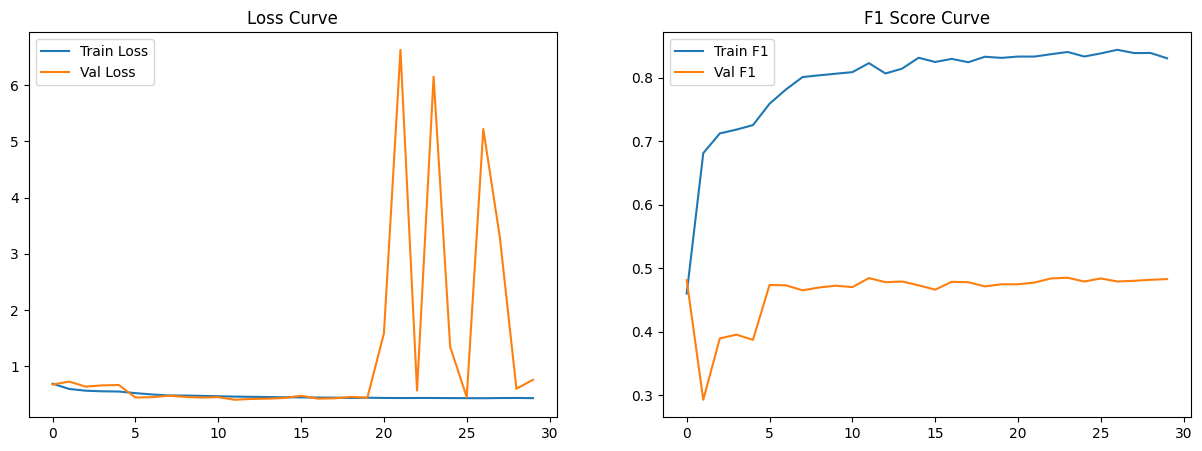

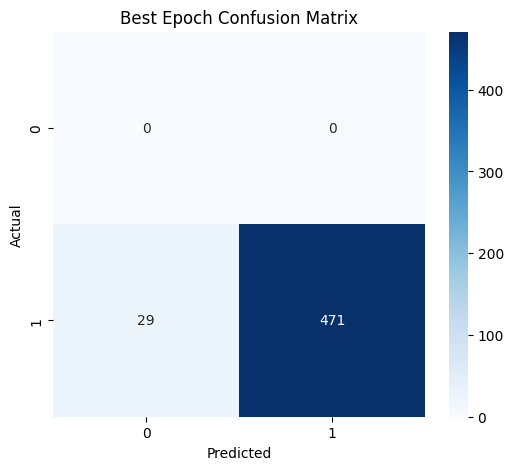

In [3]:

import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from torch.autograd import Function

# --- 1. SETUP AND HYPERPARAMETERS (From Notebook Cell 4 & 5) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 8         
EPOCHS = 30            
NUM_WORKERS = 4         
LR = 3e-4              
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True 

# Loss weights 
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# Warmup epochs and accumulation steps
WARMUP_EPOCHS = 5
EARLY_STOPPING_PATIENCE = 20
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}
best_val_preds = []
best_val_labels = []
# --- 2. TRANSFORMS (From Notebook Cell 6) ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- 3. DATASET HELPER FUNCTIONS (From Notebook Cell 7) ---
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    image_paths = []
    labels = []
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            try:
                label = int(parts[1])
            except ValueError:
                continue
                
            label = 1 if label == 1 else 0
            image_full_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels

# --- 4. MULTIDATASET CLASS (From Notebook Cell 7) ---
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                self.samples.append((img_path, label)) 
        
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}. Please ensure all Kaggle input datasets are mounted.")

            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            lbl = 1 if lbl == 1 else 0
            base_fname = os.path.basename(fname)  

            found = False
            search_subs = [
                "", "Image", "Imgs", "images", "JPEGImages", "img", 
                "Images/Train", "Images/Test",
            ]
            
            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        img_path = sample[0]
        lbl = sample[1]
        
        if len(sample) == 3:
            rdir = sample[2]
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))
            
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
            
        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

# --- 5. BACKBONE EXTRACTORS (From Notebook Cell 9) ---

# class DenseNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         for name, layer in self.features._modules.items():
#             x = layer(x)
#             if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
#                 feats.append(x)
#         return feats

# --- 5. BACKBONE EXTRACTOR (DenseNet169) ---
# --- 5. UPDATED DENSENET121 EXTRACTOR ---

# --- 5. MOBILENET V3 LARGE EXTRACTOR ---
# --- 5. EFFICIENTNET V2-S EXTRACTOR ---
# --- 5. EFFICIENTNET V2-S EXTRACTOR ---
class EfficientNetV2Extractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # efficientnet_v2_s is faster and more accurate than MobileNet
        self.base = models.efficientnet_v2_s(weights='IMAGENET1K_V1' if pretrained else None)
        self.features = self.base.features
        
    def forward(self, x):
        feats = []
        out = x
        for i, layer in enumerate(self.features):
            out = layer(out)
            # Resolution reduction points for V2-S
            if i in (2, 3, 5, 7):
                feats.append(out)
        if len(feats) == 0 or feats[-1].shape != out.shape:
            feats.append(out)
        return feats

# --- 6. EFFICIENTNET V2 MODEL ---
EFF_CHANNELS = 1280 
NUM_CLASSES = 2 

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, out_channels=EFF_CHANNELS):
        super().__init__()
        self.backbone = EfficientNetV2Extractor(pretrained=True)
        
        # Initial Freeze
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(out_channels, 512), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) 
        )
        
    def forward(self, x):
        eff_feats = self.backbone(x)[-1]
        feat = self.global_pool(eff_feats).view(x.size(0), -1)
        logits = self.classifier(feat)
        return {
            "logits": logits, 
            "feat": feat,
            "seg": torch.randn(x.size(0), 1, x.size(-2), x.size(-1)).to(x.device)
        }
# class MobileNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         out = x
#         for i, layer in enumerate(self.features):
#             out = layer(out)
#             if i in (2,5,9,12):
#                 feats.append(out)
#         if len(feats) < 4:
#             feats.append(out)
#         return feats

# --- 6. USER'S Keras-Style Fusion Model (Corrected) ---

# DENSE_CHANNELS = 1920
# # CORRECTION: The actual output features are 112, resulting in 2032 total features (1920+112). 
# # We MUST use 112 here to resolve the mat1 and mat2 dimension mismatch error (2032 vs 3200).
# # MOBILE_CHANNELS = 112 
# # TOTAL_FEATURES = DENSE_CHANNELS + MOBILE_CHANNELS # 1920 + 112 = 2032
# NUM_CLASSES = 2 


class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
supcon_loss_fn = SupConLoss(temperature=0.07)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)


# --- 8. DATA AUGMENTATION HELPERS (From Notebook Cell 20) ---

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted


# --- 9. DATA LOADING SETUP (From Notebook Cell 8) ---
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"

# --- MOCKING DATASET LOADING FOR RUNNABILITY ---
try:
# --- Scenario 1 Changes ---
# 1. 80/20 Split of testing-dataset remains the same
    testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        testing_image_paths, testing_labels, test_size=0.2, random_state=SEED
    )
    ALL_ROOT_DIRS = [
        train_dir_cod,       
        test_dir_cod,       
        train_dir_camo_cam,  
        train_dir_camo_noncam
    ]
# 2. Training includes basic sets + 80% of testing-dataset
    # --- Scenario 2 Changes ---
# 1. Training includes basic sets + 80% of testing-dataset
    ALL_TRAIN_TXTS = [
        train_cam_txt, train_noncam_txt,
        train_cam_txt2, train_noncam_txt2,
    ]# 2. Validation uses CAMO-COCO test text files ONLY
    ALL_VAL_TXTS = [test_cam_txt2, test_noncam_txt2]

    train_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_TRAIN_TXTS,
        testing_image_paths=train_paths, testing_labels=train_labels,
        weak_transform=weak_tf, strong_transform=strong_tf, use_masks=USE_SEGMENTATION
    )
    val_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_VAL_TXTS,
        testing_image_paths=None, testing_labels=None,
        weak_transform=val_tf, strong_transform=None, use_masks=USE_SEGMENTATION
    )
    def build_weighted_sampler(dataset):
        labels = [sample[1] for sample in dataset.samples]  
        counts = Counter(labels)
        total = len(labels)
        if len(counts) <= 1:
            weights = [1.0] * total
        else:
            class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
            weights = [class_weights[lbl] for lbl in labels]
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_sampler = build_weighted_sampler(train_ds)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

except RuntimeError as e:
    print(f"⚠️ Warning: Cannot access Kaggle paths ({e}). Using Mock DataLoaders for demonstration.")
    
    class MockDataset(Dataset):
        def __init__(self, num_samples, num_classes=2, img_size=IMG_SIZE):
            self.num_samples = num_samples
            self.data = torch.randn(num_samples, 3, img_size, img_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))
            self.masks = torch.randint(0, 2, (num_samples, 1, img_size, img_size)).float()

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx].clone(), self.labels[idx], self.masks[idx]

    train_ds = MockDataset(num_samples=14150) 
    val_ds = MockDataset(num_samples=6606)   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Mock DataLoaders initialized with {len(train_ds)} train and {len(val_ds)} val samples.")


# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP (From Notebook Cell 20) ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP ---
# --- 10. MODEL INSTANTIATION ---
# --- 10. MODEL INSTANTIATION ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER ---
model = EfficientNetModel().to(device)

# Mutually exclusive parameter grouping
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if 'backbone' in name:
        backbone_params.append(param)
    else:
        # All other params (classifier, global_pool, etc.) go here
        head_params.append(param)

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.1}, # Usually even lower LR for EfficientNet fine-tuning
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)

# Correctly assign the scheduler function (avoiding the previous return error)
def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        progress = float(epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_with_warmup_scheduler(opt, WARMUP_EPOCHS, EPOCHS)
scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

print(f"\nModel instantiated (EfficientNetV2-S). LR: {LR}, Backbone: Frozen")




# # Keep your scheduler, scaler, and print statements as they are
# # scheduler = get_cosine_with_warmup_scheduler(opt, WARMUP_EPOCHS, EPOCHS)
# # scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

# print(f"\nModel instantiated (DenseNet201 Only). LR: {LR}, Epochs: {EPOCHS}.")

# --- 11. TRAINING LOOP (Adapted from Notebook Cell 21) ---

def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        y_a, y_b, lam = mix_info
        if use_focal:
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

best_vf1 = 0.0
best_epoch = 0
patience_count = 0

# Inside your Epoch Loop in Section 11:
for epoch in range(1, EPOCHS + 1):
    # --- Freeze/Unfreeze Logic ---
    if epoch <= FREEZE_EPOCHS:
        for name, p in model.named_parameters():
            if 'backbone' in name:
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        print(f"\n--- [Epoch {epoch}] Unfreezing EfficientNet backbone ---")
        for p in model.parameters():
            p.requires_grad = True
            
    # The rest of your training and validation code (tqdm loop, history, etc.) follows...

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # Using weak_imgs as the primary input
        imgs = weak_imgs

        # Apply Mixup or CutMix augmentation
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        # Forward pass with Automatic Mixed Precision
        with torch.amp.autocast(device_type=device if "cuda" in device else "cpu", enabled=(device=="cuda")):
            out = model(imgs) 
            logits = out["logits"]
            
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # Auxiliary components (kept at 0 for classification focus)
            seg_loss = 0.0
            supcon_loss = 0.0 
            cons_loss = 0.0   
            dom_loss = 0.0

            total_loss = clf_loss + (GAMMA_SEG * seg_loss) + (BETA_SUPCON * supcon_loss)
            total_loss = total_loss / ACCUMULATION_STEPS 

        scaler.scale(total_loss).backward()

        # Gradient Accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() 

        running_loss += total_loss.item() * ACCUMULATION_STEPS
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate training metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} F1: {f1:.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)
            logits = out["logits"]
            
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    # Calculate validation metrics
    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Val-F1: {vf1:.4f}")
    history['train_loss'].append(running_loss/max(1,n_batches))
    history['train_f1'].append(f1)
    history['val_loss'].append(val_loss/max(1,len(val_loader)))
    history['val_f1'].append(vf1)
    # Checkpointing and Early Stopping
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_val_preds = val_y_pred
        best_val_labels = val_y_true
        # best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"⭐ New Best Model Saved (Val F1: {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
            break

print(f"\nTraining complete. Best Val F1: {best_vf1:.4f} at Epoch {best_epoch}")

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    
    # F1 Curve
    ax2.plot(history['train_f1'], label='Train F1')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_title('F1 Score Curve')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Epoch Confusion Matrix')
    plt.show()

# Call these after training finishes
plot_history(history)
plot_confusion_matrix(best_val_labels, best_val_preds)

mobilenet

Device: cuda
✅ Loaded 14604 samples from 4 root directories.
✅ Loaded 500 samples from 4 root directories.
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 122MB/s] 



Model instantiated (MobileNetV3). LR: 0.0003, Backbone: Frozen


Train 1/30: 100%|██████████| 1826/1826 [02:41<00:00, 11.32it/s]

[Epoch 1] Train Loss: 0.6952 Acc: 0.5016 F1: 0.4928


[Epoch 1] Val Loss: 0.7125 Acc: 0.1900 Val-F1: 0.1597
⭐ New Best Model Saved (Val F1: 0.1597)


Train 2/30: 100%|██████████| 1826/1826 [02:35<00:00, 11.74it/s]

[Epoch 2] Train Loss: 0.5986 Acc: 0.6847 F1: 0.6846


[Epoch 2] Val Loss: 0.5425 Acc: 0.8280 Val-F1: 0.4530
⭐ New Best Model Saved (Val F1: 0.4530)


Train 3/30: 100%|██████████| 1826/1826 [02:37<00:00, 11.56it/s]

[Epoch 3] Train Loss: 0.5628 Acc: 0.7277 F1: 0.7276


[Epoch 3] Val Loss: 0.5849 Acc: 0.7400 Val-F1: 0.4253


Train 4/30: 100%|██████████| 1826/1826 [02:34<00:00, 11.79it/s]

[Epoch 4] Train Loss: 0.5576 Acc: 0.7178 F1: 0.7177


[Epoch 4] Val Loss: 0.4670 Acc: 0.9060 Val-F1: 0.4753
⭐ New Best Model Saved (Val F1: 0.4753)


Train 5/30: 100%|██████████| 1826/1826 [02:35<00:00, 11.72it/s]

[Epoch 5] Train Loss: 0.5492 Acc: 0.7275 F1: 0.7274


[Epoch 5] Val Loss: 0.5647 Acc: 0.7620 Val-F1: 0.4325

--- [Epoch 6] Unfreezing MobileNet backbone ---


Train 6/30: 100%|██████████| 1826/1826 [03:03<00:00,  9.94it/s]

[Epoch 6] Train Loss: 0.5355 Acc: 0.7457 F1: 0.7455


[Epoch 6] Val Loss: 0.4909 Acc: 0.8520 Val-F1: 0.4600


Train 7/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.80it/s]


[Epoch 7] Train Loss: 0.5184 Acc: 0.7628 F1: 0.7627
[Epoch 7] Val Loss: 0.5061 Acc: 0.8240 Val-F1: 0.4518


Train 8/30: 100%|██████████| 1826/1826 [02:48<00:00, 10.85it/s]

[Epoch 8] Train Loss: 0.5069 Acc: 0.7749 F1: 0.7746


[Epoch 8] Val Loss: 0.4537 Acc: 0.8880 Val-F1: 0.4703


Train 9/30: 100%|██████████| 1826/1826 [02:48<00:00, 10.82it/s]


[Epoch 9] Train Loss: 0.5097 Acc: 0.7779 F1: 0.7778
[Epoch 9] Val Loss: 0.4674 Acc: 0.8740 Val-F1: 0.4664


Train 10/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.76it/s]


[Epoch 10] Train Loss: 0.4996 Acc: 0.7769 F1: 0.7769
[Epoch 10] Val Loss: 0.5368 Acc: 0.8200 Val-F1: 0.4505


Train 11/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.79it/s]


[Epoch 11] Train Loss: 0.4996 Acc: 0.7810 F1: 0.7810
[Epoch 11] Val Loss: 0.4870 Acc: 0.8400 Val-F1: 0.4565


Train 12/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.71it/s]

[Epoch 12] Train Loss: 0.4931 Acc: 0.7941 F1: 0.7941


[Epoch 12] Val Loss: 0.4896 Acc: 0.8440 Val-F1: 0.4577


Train 13/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.80it/s]

[Epoch 13] Train Loss: 0.4912 Acc: 0.7805 F1: 0.7805


[Epoch 13] Val Loss: 0.4783 Acc: 0.8640 Val-F1: 0.4635


Train 14/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.73it/s]

[Epoch 14] Train Loss: 0.4836 Acc: 0.7911 F1: 0.7910


[Epoch 14] Val Loss: 0.5014 Acc: 0.8640 Val-F1: 0.4635


Train 15/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.72it/s]


[Epoch 15] Train Loss: 0.4826 Acc: 0.7992 F1: 0.7991
[Epoch 15] Val Loss: 0.4481 Acc: 0.8920 Val-F1: 0.4715


Train 16/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.80it/s]

[Epoch 16] Train Loss: 0.4779 Acc: 0.8021 F1: 0.8021


[Epoch 16] Val Loss: 0.4879 Acc: 0.8660 Val-F1: 0.4641


Train 17/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.75it/s]


[Epoch 17] Train Loss: 0.4787 Acc: 0.8014 F1: 0.8014
[Epoch 17] Val Loss: 0.4905 Acc: 0.8700 Val-F1: 0.4652


Train 18/30: 100%|██████████| 1826/1826 [02:51<00:00, 10.65it/s]


[Epoch 18] Train Loss: 0.4758 Acc: 0.7977 F1: 0.7977
[Epoch 18] Val Loss: 0.5105 Acc: 0.8560 Val-F1: 0.4612


Train 19/30: 100%|██████████| 1826/1826 [02:52<00:00, 10.62it/s]

[Epoch 19] Train Loss: 0.4708 Acc: 0.7998 F1: 0.7998


[Epoch 19] Val Loss: 0.5552 Acc: 0.8700 Val-F1: 0.4652


Train 20/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.71it/s]

[Epoch 20] Train Loss: 0.4741 Acc: 0.8007 F1: 0.8007


[Epoch 20] Val Loss: 0.5851 Acc: 0.8520 Val-F1: 0.4600


Train 21/30: 100%|██████████| 1826/1826 [02:54<00:00, 10.47it/s]

[Epoch 21] Train Loss: 0.4713 Acc: 0.8052 F1: 0.8052


[Epoch 21] Val Loss: 0.5683 Acc: 0.8540 Val-F1: 0.4606


Train 22/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.71it/s]

[Epoch 22] Train Loss: 0.4692 Acc: 0.8033 F1: 0.8032


[Epoch 22] Val Loss: 0.5452 Acc: 0.8520 Val-F1: 0.4600


Train 23/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.74it/s]

[Epoch 23] Train Loss: 0.4674 Acc: 0.8064 F1: 0.8064


[Epoch 23] Val Loss: 0.6627 Acc: 0.8480 Val-F1: 0.4589


Train 24/30: 100%|██████████| 1826/1826 [02:51<00:00, 10.66it/s]

[Epoch 24] Train Loss: 0.4706 Acc: 0.8034 F1: 0.8034


[Epoch 24] Val Loss: 0.6381 Acc: 0.8280 Val-F1: 0.4530
Early stopping triggered after 20 epochs of no improvement.

Training complete. Best Val F1: 0.4753 at Epoch 4


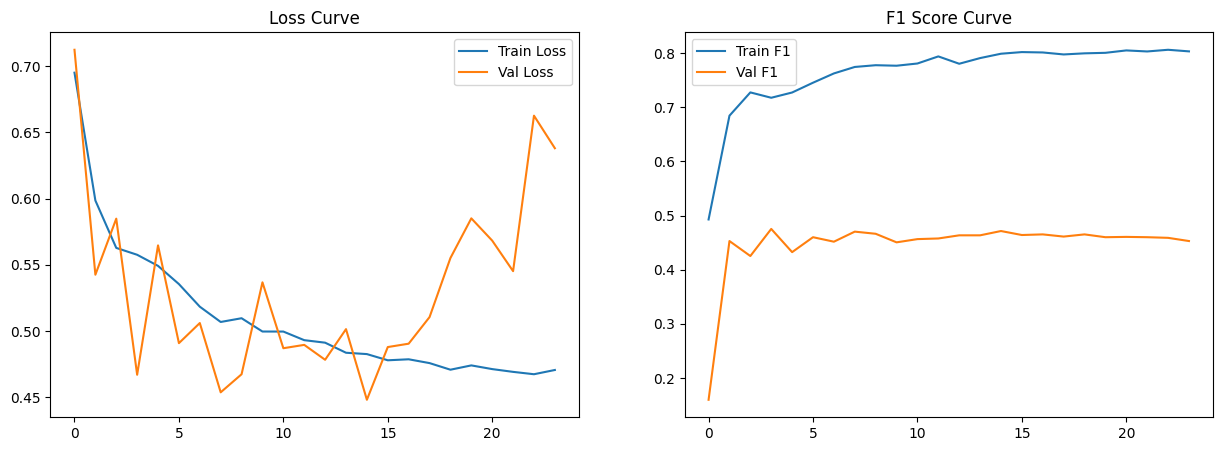

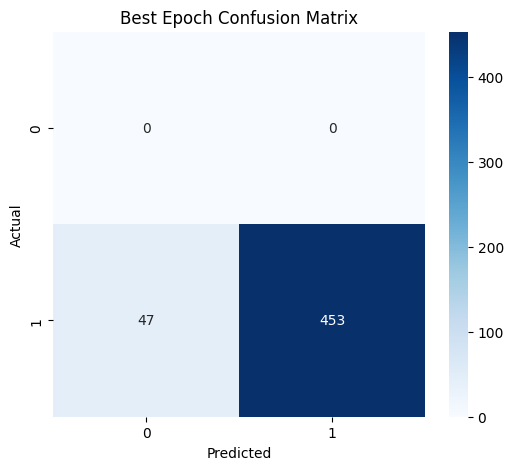

In [4]:

import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from torch.autograd import Function

# --- 1. SETUP AND HYPERPARAMETERS (From Notebook Cell 4 & 5) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 8         
EPOCHS = 30            
NUM_WORKERS = 4         
LR = 3e-4              
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True 

# Loss weights 
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# Warmup epochs and accumulation steps
WARMUP_EPOCHS = 5
EARLY_STOPPING_PATIENCE = 20
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}
best_val_preds = []
best_val_labels = []
# --- 2. TRANSFORMS (From Notebook Cell 6) ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- 3. DATASET HELPER FUNCTIONS (From Notebook Cell 7) ---
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    image_paths = []
    labels = []
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            try:
                label = int(parts[1])
            except ValueError:
                continue
                
            label = 1 if label == 1 else 0
            image_full_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels

# --- 4. MULTIDATASET CLASS (From Notebook Cell 7) ---
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                self.samples.append((img_path, label)) 
        
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}. Please ensure all Kaggle input datasets are mounted.")

            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            lbl = 1 if lbl == 1 else 0
            base_fname = os.path.basename(fname)  

            found = False
            search_subs = [
                "", "Image", "Imgs", "images", "JPEGImages", "img", 
                "Images/Train", "Images/Test",
            ]
            
            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        img_path = sample[0]
        lbl = sample[1]
        
        if len(sample) == 3:
            rdir = sample[2]
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))
            
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
            
        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

# --- 5. BACKBONE EXTRACTORS (From Notebook Cell 9) ---

# class DenseNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         for name, layer in self.features._modules.items():
#             x = layer(x)
#             if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
#                 feats.append(x)
#         return feats

# --- 5. BACKBONE EXTRACTOR (DenseNet169) ---
# --- 5. UPDATED DENSENET121 EXTRACTOR ---

# --- 5. MOBILENET V3 LARGE EXTRACTOR ---
class MobileNetV3Extractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Using mobilenet_v3_large for high performance/efficiency balance
        self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
        
    def forward(self, x):
        feats = []
        out = x
        for i, layer in enumerate(self.features):
            out = layer(out)
            # MobileNetV3 Large has 19 blocks in its feature extractor
            # We extract features at common reduction points (layers 3, 6, 12, 15)
            if i in (3, 6, 12, 15):
                feats.append(out)
        
        # Ensure the final output is included
        if len(feats) == 0 or feats[-1].shape != out.shape:
            feats.append(out)
        return feats

# --- 6. MOBILENET V3 MODEL ---
MOBILE_CHANNELS = 960  # Feature dimension for MobileNetV3-Large
NUM_CLASSES = 2 

class MobileNetModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, out_channels=MOBILE_CHANNELS):
        super().__init__()
        
        self.backbone = MobileNetV3Extractor(pretrained=True)
        
        # Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier input is now 960
        self.classifier = nn.Sequential(
            nn.Linear(out_channels, 512), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) 
        )
        
    def forward(self, x):
        # Feature Extraction
        mobile_feats = self.backbone(x)[-1]
        
        # Global Pooling [Batch, 960, 7, 7] -> [Batch, 960]
        feat = self.global_pool(mobile_feats).view(x.size(0), -1)

        logits = self.classifier(feat)
        
        return {
            "logits": logits, 
            "feat": feat,
            "seg": torch.randn(x.size(0), 1, x.size(-2), x.size(-1)).to(x.device)
        }
# class MobileNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         out = x
#         for i, layer in enumerate(self.features):
#             out = layer(out)
#             if i in (2,5,9,12):
#                 feats.append(out)
#         if len(feats) < 4:
#             feats.append(out)
#         return feats

# --- 6. USER'S Keras-Style Fusion Model (Corrected) ---

# DENSE_CHANNELS = 1920
# # CORRECTION: The actual output features are 112, resulting in 2032 total features (1920+112). 
# # We MUST use 112 here to resolve the mat1 and mat2 dimension mismatch error (2032 vs 3200).
# # MOBILE_CHANNELS = 112 
# # TOTAL_FEATURES = DENSE_CHANNELS + MOBILE_CHANNELS # 1920 + 112 = 2032
# NUM_CLASSES = 2 


class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
supcon_loss_fn = SupConLoss(temperature=0.07)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)


# --- 8. DATA AUGMENTATION HELPERS (From Notebook Cell 20) ---

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted


# --- 9. DATA LOADING SETUP (From Notebook Cell 8) ---
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"

# --- MOCKING DATASET LOADING FOR RUNNABILITY ---
try:
# --- Scenario 1 Changes ---
# 1. 80/20 Split of testing-dataset remains the same
    testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        testing_image_paths, testing_labels, test_size=0.2, random_state=SEED
    )
    ALL_ROOT_DIRS = [
        train_dir_cod,       
        test_dir_cod,       
        train_dir_camo_cam,  
        train_dir_camo_noncam
    ]
# 2. Training includes basic sets + 80% of testing-dataset
    # --- Scenario 2 Changes ---
# 1. Training includes basic sets + 80% of testing-dataset
    ALL_TRAIN_TXTS = [
        train_cam_txt, train_noncam_txt,
        train_cam_txt2, train_noncam_txt2,
    ]# 2. Validation uses CAMO-COCO test text files ONLY
    ALL_VAL_TXTS = [test_cam_txt2, test_noncam_txt2]

    train_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_TRAIN_TXTS,
        testing_image_paths=train_paths, testing_labels=train_labels,
        weak_transform=weak_tf, strong_transform=strong_tf, use_masks=USE_SEGMENTATION
    )
    val_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_VAL_TXTS,
        testing_image_paths=None, testing_labels=None,
        weak_transform=val_tf, strong_transform=None, use_masks=USE_SEGMENTATION
    )
    def build_weighted_sampler(dataset):
        labels = [sample[1] for sample in dataset.samples]  
        counts = Counter(labels)
        total = len(labels)
        if len(counts) <= 1:
            weights = [1.0] * total
        else:
            class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
            weights = [class_weights[lbl] for lbl in labels]
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_sampler = build_weighted_sampler(train_ds)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

except RuntimeError as e:
    print(f"⚠️ Warning: Cannot access Kaggle paths ({e}). Using Mock DataLoaders for demonstration.")
    
    class MockDataset(Dataset):
        def __init__(self, num_samples, num_classes=2, img_size=IMG_SIZE):
            self.num_samples = num_samples
            self.data = torch.randn(num_samples, 3, img_size, img_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))
            self.masks = torch.randint(0, 2, (num_samples, 1, img_size, img_size)).float()

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx].clone(), self.labels[idx], self.masks[idx]

    train_ds = MockDataset(num_samples=14150) 
    val_ds = MockDataset(num_samples=6606)   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Mock DataLoaders initialized with {len(train_ds)} train and {len(val_ds)} val samples.")


# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP (From Notebook Cell 20) ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP ---
# --- 10. MODEL INSTANTIATION ---
# --- 10. MODEL INSTANTIATION ---
model = MobileNetModel().to(device)
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        progress = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return LambdaLR(optimizer, lr_lambda)

# Adjusted to find 'backbone' instead of 'densenet_base'
backbone_params = [p for n, p in model.named_parameters() if 'backbone' in n]
head_params = [p for n, p in model.named_parameters() if 'classifier' in n]

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.2}, 
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)

scheduler = get_cosine_with_warmup_scheduler(
    opt,
    warmup_epochs=WARMUP_EPOCHS,
    total_epochs=EPOCHS
)

scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

print(f"\nModel instantiated (MobileNetV3). LR: {LR}, Backbone: Frozen")



# # Keep your scheduler, scaler, and print statements as they are
# # scheduler = get_cosine_with_warmup_scheduler(opt, WARMUP_EPOCHS, EPOCHS)
# # scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

# print(f"\nModel instantiated (DenseNet201 Only). LR: {LR}, Epochs: {EPOCHS}.")

# --- 11. TRAINING LOOP (Adapted from Notebook Cell 21) ---

def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        y_a, y_b, lam = mix_info
        if use_focal:
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

best_vf1 = 0.0
best_epoch = 0
patience_count = 0

for epoch in range(1, EPOCHS + 1):
    # --- Updated Freeze/Unfreeze Logic for DenseNet ---
    # --- Inside Section 11 loop ---
# --- Inside Section 11 loop ---
    if epoch <= FREEZE_EPOCHS:
        for name, p in model.named_parameters():
            if 'backbone' in name: # Changed from 'densenet_base'
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        print(f"\n--- [Epoch {epoch}] Unfreezing MobileNet backbone ---")
        for p in model.parameters():
            p.requires_grad = True

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # Using weak_imgs as the primary input
        imgs = weak_imgs

        # Apply Mixup or CutMix augmentation
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        # Forward pass with Automatic Mixed Precision
        with torch.amp.autocast(device_type=device if "cuda" in device else "cpu", enabled=(device=="cuda")):
            out = model(imgs) 
            logits = out["logits"]
            
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # Auxiliary components (kept at 0 for classification focus)
            seg_loss = 0.0
            supcon_loss = 0.0 
            cons_loss = 0.0   
            dom_loss = 0.0

            total_loss = clf_loss + (GAMMA_SEG * seg_loss) + (BETA_SUPCON * supcon_loss)
            total_loss = total_loss / ACCUMULATION_STEPS 

        scaler.scale(total_loss).backward()

        # Gradient Accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() 

        running_loss += total_loss.item() * ACCUMULATION_STEPS
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate training metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} F1: {f1:.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)
            logits = out["logits"]
            
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    # Calculate validation metrics
    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Val-F1: {vf1:.4f}")
    history['train_loss'].append(running_loss/max(1,n_batches))
    history['train_f1'].append(f1)
    history['val_loss'].append(val_loss/max(1,len(val_loader)))
    history['val_f1'].append(vf1)
    # Checkpointing and Early Stopping
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_val_preds = val_y_pred
        best_val_labels = val_y_true
        # best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"⭐ New Best Model Saved (Val F1: {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
            break

print(f"\nTraining complete. Best Val F1: {best_vf1:.4f} at Epoch {best_epoch}")

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    
    # F1 Curve
    ax2.plot(history['train_f1'], label='Train F1')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_title('F1 Score Curve')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Epoch Confusion Matrix')
    plt.show()

# Call these after training finishes
plot_history(history)
plot_confusion_matrix(best_val_labels, best_val_preds)

densener121


Device: cuda
✅ Loaded 14604 samples from 4 root directories.
✅ Loaded 500 samples from 4 root directories.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]



Model instantiated (DenseNet121). LR: 0.0003, Backbone: Frozen

Model instantiated (DenseNet201 Only). LR: 0.0003, Epochs: 30.


Train 1/30: 100%|██████████| 1826/1826 [02:48<00:00, 10.83it/s]

[Epoch 1] Train Loss: 0.6933 Acc: 0.5080 F1: 0.3579


[Epoch 1] Val Loss: 0.6799 Acc: 1.0000 Val-F1: 1.0000
⭐ New Best Model Saved (Val F1: 1.0000)


Train 2/30: 100%|██████████| 1826/1826 [02:46<00:00, 10.97it/s]

[Epoch 2] Train Loss: 0.6031 Acc: 0.6904 F1: 0.6897


[Epoch 2] Val Loss: 0.7396 Acc: 0.6000 Val-F1: 0.3750


Train 3/30: 100%|██████████| 1826/1826 [02:50<00:00, 10.71it/s]

[Epoch 3] Train Loss: 0.5554 Acc: 0.7303 F1: 0.7300


[Epoch 3] Val Loss: 0.6986 Acc: 0.6420 Val-F1: 0.3910


Train 4/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.78it/s]

[Epoch 4] Train Loss: 0.5468 Acc: 0.7365 F1: 0.7363


[Epoch 4] Val Loss: 0.6721 Acc: 0.6720 Val-F1: 0.4019


Train 5/30: 100%|██████████| 1826/1826 [02:49<00:00, 10.77it/s]


[Epoch 5] Train Loss: 0.5364 Acc: 0.7453 F1: 0.7451
[Epoch 5] Val Loss: 0.5447 Acc: 0.8020 Val-F1: 0.4451

--- [Epoch 6] Unfreezing DenseNet backbone for fine-tuning ---


Train 6/30: 100%|██████████| 1826/1826 [03:32<00:00,  8.58it/s]

[Epoch 6] Train Loss: 0.5275 Acc: 0.7546 F1: 0.7545


[Epoch 6] Val Loss: 0.4308 Acc: 0.9240 Val-F1: 0.4802


Train 7/30: 100%|██████████| 1826/1826 [03:33<00:00,  8.57it/s]

[Epoch 7] Train Loss: 0.5049 Acc: 0.7763 F1: 0.7763


[Epoch 7] Val Loss: 0.4476 Acc: 0.9020 Val-F1: 0.4742


Train 8/30: 100%|██████████| 1826/1826 [03:34<00:00,  8.50it/s]

[Epoch 8] Train Loss: 0.4947 Acc: 0.7900 F1: 0.7900


[Epoch 8] Val Loss: 0.4713 Acc: 0.8680 Val-F1: 0.4647


Train 9/30: 100%|██████████| 1826/1826 [03:36<00:00,  8.44it/s]

[Epoch 9] Train Loss: 0.4972 Acc: 0.7845 F1: 0.7844


[Epoch 9] Val Loss: 0.4773 Acc: 0.8780 Val-F1: 0.4675


Train 10/30: 100%|██████████| 1826/1826 [03:35<00:00,  8.45it/s]

[Epoch 10] Train Loss: 0.4809 Acc: 0.8002 F1: 0.8001


[Epoch 10] Val Loss: 0.4386 Acc: 0.8980 Val-F1: 0.4731


Train 11/30: 100%|██████████| 1826/1826 [03:36<00:00,  8.42it/s]

[Epoch 11] Train Loss: 0.4773 Acc: 0.7937 F1: 0.7937


[Epoch 11] Val Loss: 0.4571 Acc: 0.8920 Val-F1: 0.4715


Train 12/30: 100%|██████████| 1826/1826 [03:35<00:00,  8.48it/s]

[Epoch 12] Train Loss: 0.4761 Acc: 0.8045 F1: 0.8045


[Epoch 12] Val Loss: 0.4586 Acc: 0.8880 Val-F1: 0.4703


Train 13/30: 100%|██████████| 1826/1826 [03:34<00:00,  8.50it/s]

[Epoch 13] Train Loss: 0.4714 Acc: 0.7910 F1: 0.7910


[Epoch 13] Val Loss: 0.4183 Acc: 0.9280 Val-F1: 0.4813


Train 14/30: 100%|██████████| 1826/1826 [03:34<00:00,  8.52it/s]

[Epoch 14] Train Loss: 0.4641 Acc: 0.8098 F1: 0.8098


[Epoch 14] Val Loss: 0.4182 Acc: 0.9180 Val-F1: 0.4786


Train 15/30: 100%|██████████| 1826/1826 [03:34<00:00,  8.53it/s]

[Epoch 15] Train Loss: 0.4640 Acc: 0.8096 F1: 0.8096


[Epoch 15] Val Loss: 0.4409 Acc: 0.9020 Val-F1: 0.4742


Train 16/30: 100%|██████████| 1826/1826 [03:32<00:00,  8.57it/s]

[Epoch 16] Train Loss: 0.4583 Acc: 0.8166 F1: 0.8166


[Epoch 16] Val Loss: 0.4372 Acc: 0.9040 Val-F1: 0.4748


Train 17/30: 100%|██████████| 1826/1826 [03:31<00:00,  8.63it/s]

[Epoch 17] Train Loss: 0.4535 Acc: 0.8214 F1: 0.8213


[Epoch 17] Val Loss: 0.4121 Acc: 0.9280 Val-F1: 0.4813


Train 18/30: 100%|██████████| 1826/1826 [03:31<00:00,  8.61it/s]

[Epoch 18] Train Loss: 0.4555 Acc: 0.8137 F1: 0.8137


[Epoch 18] Val Loss: 0.4246 Acc: 0.9180 Val-F1: 0.4786


Train 19/30: 100%|██████████| 1826/1826 [03:31<00:00,  8.65it/s]

[Epoch 19] Train Loss: 0.4488 Acc: 0.8185 F1: 0.8185


[Epoch 19] Val Loss: 0.4397 Acc: 0.8940 Val-F1: 0.4720


Train 20/30: 100%|██████████| 1826/1826 [03:31<00:00,  8.62it/s]

[Epoch 20] Train Loss: 0.4481 Acc: 0.8258 F1: 0.8258


[Epoch 20] Val Loss: 0.4028 Acc: 0.9380 Val-F1: 0.4840


Train 21/30: 100%|██████████| 1826/1826 [03:32<00:00,  8.61it/s]

[Epoch 21] Train Loss: 0.4463 Acc: 0.8270 F1: 0.8270


[Epoch 21] Val Loss: 0.3975 Acc: 0.9480 Val-F1: 0.4867
Early stopping triggered after 20 epochs of no improvement.

Training complete. Best Val F1: 1.0000 at Epoch 1


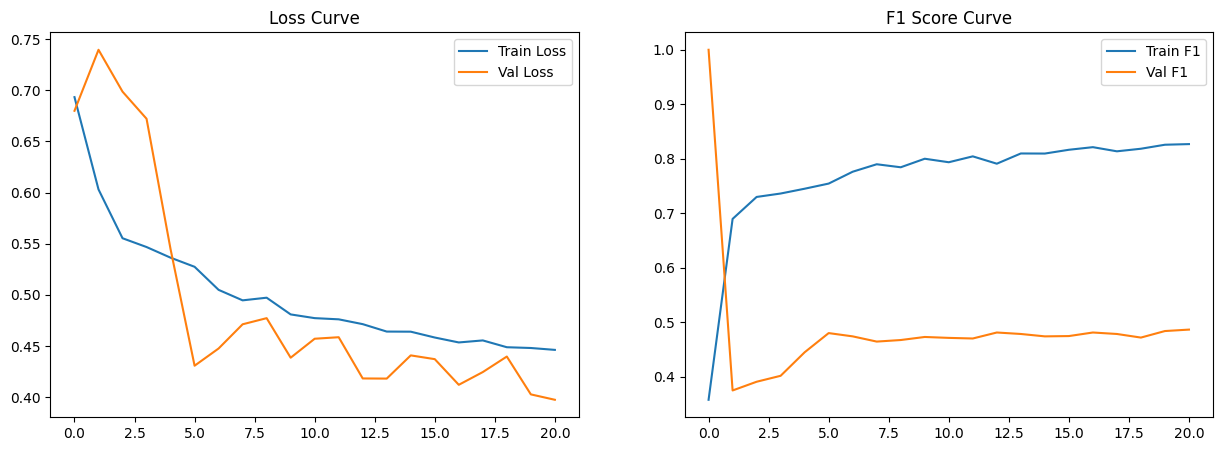

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


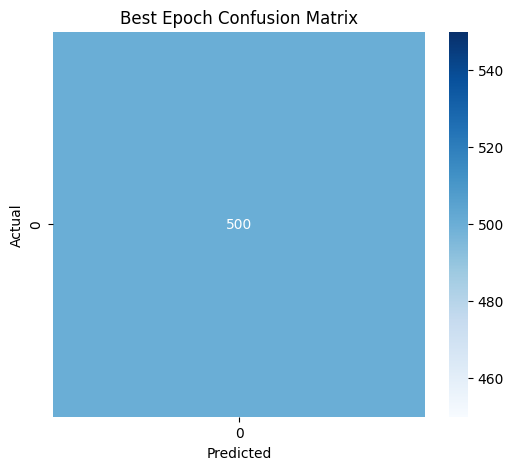

In [5]:

import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from torch.autograd import Function

# --- 1. SETUP AND HYPERPARAMETERS (From Notebook Cell 4 & 5) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 8         
EPOCHS = 30            
NUM_WORKERS = 4         
LR = 3e-4              
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True 

# Loss weights 
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# Warmup epochs and accumulation steps
WARMUP_EPOCHS = 5
EARLY_STOPPING_PATIENCE = 20
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}
best_val_preds = []
best_val_labels = []
# --- 2. TRANSFORMS (From Notebook Cell 6) ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- 3. DATASET HELPER FUNCTIONS (From Notebook Cell 7) ---
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    image_paths = []
    labels = []
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            try:
                label = int(parts[1])
            except ValueError:
                continue
                
            label = 1 if label == 1 else 0
            image_full_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels

# --- 4. MULTIDATASET CLASS (From Notebook Cell 7) ---
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                self.samples.append((img_path, label)) 
        
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}. Please ensure all Kaggle input datasets are mounted.")

            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            lbl = 1 if lbl == 1 else 0
            base_fname = os.path.basename(fname)  

            found = False
            search_subs = [
                "", "Image", "Imgs", "images", "JPEGImages", "img", 
                "Images/Train", "Images/Test",
            ]
            
            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        img_path = sample[0]
        lbl = sample[1]
        
        if len(sample) == 3:
            rdir = sample[2]
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))
            
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
            
        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

# --- 5. BACKBONE EXTRACTORS (From Notebook Cell 9) ---

# class DenseNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         for name, layer in self.features._modules.items():
#             x = layer(x)
#             if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
#                 feats.append(x)
#         return feats

# --- 5. BACKBONE EXTRACTOR (DenseNet169) ---
# --- 5. UPDATED DENSENET121 EXTRACTOR ---
class DenseNet121Extractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Using densenet121 instead of densenet201
        self.features = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None).features
        
    def forward(self, x):
        feats = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            # Keeping the same block-level feature extraction structure
            if name in ["denseblock1", "denseblock2", "denseblock3", "denseblock4"]:
                feats.append(x)
        return feats

# --- 6. DENSENET121 ONLY MODEL ---
DENSE121_CHANNELS = 1024  # DenseNet121 final feature dimension
NUM_CLASSES = 2 

class DenseNet121Model(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, out_channels=DENSE121_CHANNELS):
        super().__init__()
        
        self.densenet_base = DenseNet121Extractor(pretrained=True)
        
        # Initial Freeze logic
        for param in self.densenet_base.parameters():
            param.requires_grad = False
            
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier input is now 1024
        self.classifier = nn.Sequential(
            nn.Linear(out_channels, 512), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) 
        )
        
        self.use_seg = False 
        self.domain_head = nn.Identity()
        
    def forward(self, x, grl_lambda=0.0):
        # Feature Extraction
        densenet_feats = self.densenet_base(x)[-1]
        
        # Pooling [Batch, 1024, 7, 7] -> [Batch, 1024]
        feat = self.global_pool(densenet_feats).view(x.size(0), -1)

        logits = self.classifier(feat)
        
        return {
            "logits": logits, 
            "feat": feat,
            "domain_logits": torch.randn(x.size(0), 2).to(x.device), 
            "seg": torch.randn(x.size(0), 1, x.size(-2), x.size(-1)).to(x.device)
        }
# class MobileNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         out = x
#         for i, layer in enumerate(self.features):
#             out = layer(out)
#             if i in (2,5,9,12):
#                 feats.append(out)
#         if len(feats) < 4:
#             feats.append(out)
#         return feats

# --- 6. USER'S Keras-Style Fusion Model (Corrected) ---

# DENSE_CHANNELS = 1920
# # CORRECTION: The actual output features are 112, resulting in 2032 total features (1920+112). 
# # We MUST use 112 here to resolve the mat1 and mat2 dimension mismatch error (2032 vs 3200).
# # MOBILE_CHANNELS = 112 
# # TOTAL_FEATURES = DENSE_CHANNELS + MOBILE_CHANNELS # 1920 + 112 = 2032
# NUM_CLASSES = 2 


class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
supcon_loss_fn = SupConLoss(temperature=0.07)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)


# --- 8. DATA AUGMENTATION HELPERS (From Notebook Cell 20) ---

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted


# --- 9. DATA LOADING SETUP (From Notebook Cell 8) ---
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"

# --- MOCKING DATASET LOADING FOR RUNNABILITY ---
try:
# --- Scenario 1 Changes ---
# 1. 80/20 Split of testing-dataset remains the same
    testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        testing_image_paths, testing_labels, test_size=0.2, random_state=SEED
    )
    ALL_ROOT_DIRS = [
        train_dir_cod,       
        test_dir_cod,       
        train_dir_camo_cam,  
        train_dir_camo_noncam
    ]
# 2. Training includes basic sets + 80% of testing-dataset
    # --- Scenario 2 Changes ---
# 1. Training includes basic sets + 80% of testing-dataset
    ALL_TRAIN_TXTS = [
        train_cam_txt, train_noncam_txt,
        train_cam_txt2, train_noncam_txt2,
    ]# 2. Validation uses CAMO-COCO test text files ONLY
    ALL_VAL_TXTS = [test_cam_txt2, test_noncam_txt2]

    train_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_TRAIN_TXTS,
        testing_image_paths=train_paths, testing_labels=train_labels,
        weak_transform=weak_tf, strong_transform=strong_tf, use_masks=USE_SEGMENTATION
    )
    val_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_VAL_TXTS,
        testing_image_paths=None, testing_labels=None,
        weak_transform=val_tf, strong_transform=None, use_masks=USE_SEGMENTATION
    )
    def build_weighted_sampler(dataset):
        labels = [sample[1] for sample in dataset.samples]  
        counts = Counter(labels)
        total = len(labels)
        if len(counts) <= 1:
            weights = [1.0] * total
        else:
            class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
            weights = [class_weights[lbl] for lbl in labels]
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_sampler = build_weighted_sampler(train_ds)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

except RuntimeError as e:
    print(f"⚠️ Warning: Cannot access Kaggle paths ({e}). Using Mock DataLoaders for demonstration.")
    
    class MockDataset(Dataset):
        def __init__(self, num_samples, num_classes=2, img_size=IMG_SIZE):
            self.num_samples = num_samples
            self.data = torch.randn(num_samples, 3, img_size, img_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))
            self.masks = torch.randint(0, 2, (num_samples, 1, img_size, img_size)).float()

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx].clone(), self.labels[idx], self.masks[idx]

    train_ds = MockDataset(num_samples=14150) 
    val_ds = MockDataset(num_samples=6606)   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Mock DataLoaders initialized with {len(train_ds)} train and {len(val_ds)} val samples.")


# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP (From Notebook Cell 20) ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP ---
# --- 10. MODEL INSTANTIATION ---
model = DenseNet121Model().to(device)
print(f"\nModel instantiated (DenseNet121). LR: {LR}, Backbone: Frozen")
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        progress = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return LambdaLR(optimizer, lr_lambda)

backbone_params = [p for n, p in model.named_parameters() if 'densenet_base' in n]
head_params = [p for n, p in model.named_parameters() if 'classifier' in n]

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.2}, 
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)

# Re-include the scheduler and scaler (ensure the function is defined)
scheduler = get_cosine_with_warmup_scheduler(
    opt,
    warmup_epochs=WARMUP_EPOCHS,
    total_epochs=EPOCHS
)

scaler = torch.amp.GradScaler(enabled=(device=="cuda"))


# Keep your scheduler, scaler, and print statements as they are
# scheduler = get_cosine_with_warmup_scheduler(opt, WARMUP_EPOCHS, EPOCHS)
# scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

print(f"\nModel instantiated (DenseNet201 Only). LR: {LR}, Epochs: {EPOCHS}.")

# --- 11. TRAINING LOOP (Adapted from Notebook Cell 21) ---

def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        y_a, y_b, lam = mix_info
        if use_focal:
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

best_vf1 = 0.0
best_epoch = 0
patience_count = 0

for epoch in range(1, EPOCHS + 1):
    # --- Updated Freeze/Unfreeze Logic for DenseNet ---
    if epoch <= FREEZE_EPOCHS:
        for name, p in model.named_parameters():
            if 'densenet_base' in name:
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        print(f"\n--- [Epoch {epoch}] Unfreezing DenseNet backbone for fine-tuning ---")
        for p in model.parameters():
            p.requires_grad = True

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # Using weak_imgs as the primary input
        imgs = weak_imgs

        # Apply Mixup or CutMix augmentation
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        # Forward pass with Automatic Mixed Precision
        with torch.amp.autocast(device_type=device if "cuda" in device else "cpu", enabled=(device=="cuda")):
            out = model(imgs) 
            logits = out["logits"]
            
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # Auxiliary components (kept at 0 for classification focus)
            seg_loss = 0.0
            supcon_loss = 0.0 
            cons_loss = 0.0   
            dom_loss = 0.0

            total_loss = clf_loss + (GAMMA_SEG * seg_loss) + (BETA_SUPCON * supcon_loss)
            total_loss = total_loss / ACCUMULATION_STEPS 

        scaler.scale(total_loss).backward()

        # Gradient Accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() 

        running_loss += total_loss.item() * ACCUMULATION_STEPS
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate training metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} F1: {f1:.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)
            logits = out["logits"]
            
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    # Calculate validation metrics
    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Val-F1: {vf1:.4f}")
    history['train_loss'].append(running_loss/max(1,n_batches))
    history['train_f1'].append(f1)
    history['val_loss'].append(val_loss/max(1,len(val_loader)))
    history['val_f1'].append(vf1)
    # Checkpointing and Early Stopping
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_val_preds = val_y_pred
        best_val_labels = val_y_true
        # best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"⭐ New Best Model Saved (Val F1: {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
            break

print(f"\nTraining complete. Best Val F1: {best_vf1:.4f} at Epoch {best_epoch}")

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    
    # F1 Curve
    ax2.plot(history['train_f1'], label='Train F1')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_title('F1 Score Curve')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Epoch Confusion Matrix')
    plt.show()

# Call these after training finishes
plot_history(history)
plot_confusion_matrix(best_val_labels, best_val_preds)

densenet169

Inception V3

Device: cuda
✅ Loaded 14604 samples from 4 root directories.
✅ Loaded 500 samples from 4 root directories.
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 171MB/s] 



Model instantiated (InceptionV3). Image Size: 299


Train 1/30: 100%|██████████| 1826/1826 [02:46<00:00, 10.94it/s]

[Epoch 1] Train Loss: 0.6940 Acc: 0.5006 F1: 0.4382


[Epoch 1] Val Loss: 0.6644 Acc: 0.9760 Val-F1: 0.4939
⭐ New Best Model Saved (Val F1: 0.4939)


Train 2/30: 100%|██████████| 1826/1826 [02:48<00:00, 10.83it/s]

[Epoch 2] Train Loss: 0.6098 Acc: 0.6656 F1: 0.6656


[Epoch 2] Val Loss: 0.7126 Acc: 0.5700 Val-F1: 0.3631


Train 3/30: 100%|██████████| 1826/1826 [02:46<00:00, 10.96it/s]


[Epoch 3] Train Loss: 0.5832 Acc: 0.6951 F1: 0.6947
[Epoch 3] Val Loss: 0.6313 Acc: 0.6920 Val-F1: 0.4090


Train 4/30: 100%|██████████| 1826/1826 [02:48<00:00, 10.84it/s]

[Epoch 4] Train Loss: 0.5806 Acc: 0.6968 F1: 0.6964


[Epoch 4] Val Loss: 0.5176 Acc: 0.8620 Val-F1: 0.4629


Train 5/30: 100%|██████████| 1826/1826 [02:47<00:00, 10.88it/s]

[Epoch 5] Train Loss: 0.5791 Acc: 0.6956 F1: 0.6955


[Epoch 5] Val Loss: 0.6312 Acc: 0.7080 Val-F1: 0.4145

--- [Epoch 6] Unfreezing DenseNet backbone for fine-tuning ---


Train 6/30: 100%|██████████| 1826/1826 [03:10<00:00,  9.57it/s]

[Epoch 6] Train Loss: 0.5523 Acc: 0.7306 F1: 0.7305


[Epoch 6] Val Loss: 0.5361 Acc: 0.8280 Val-F1: 0.4530


Train 7/30: 100%|██████████| 1826/1826 [03:10<00:00,  9.61it/s]


[Epoch 7] Train Loss: 0.5232 Acc: 0.7629 F1: 0.7625
[Epoch 7] Val Loss: 0.5179 Acc: 0.8380 Val-F1: 0.4559


Train 8/30: 100%|██████████| 1826/1826 [03:06<00:00,  9.77it/s]


[Epoch 8] Train Loss: 0.5122 Acc: 0.7668 F1: 0.7667
[Epoch 8] Val Loss: 0.5193 Acc: 0.8160 Val-F1: 0.4493


Train 9/30: 100%|██████████| 1826/1826 [03:08<00:00,  9.68it/s]


[Epoch 9] Train Loss: 0.5095 Acc: 0.7768 F1: 0.7766
[Epoch 9] Val Loss: 0.4799 Acc: 0.8720 Val-F1: 0.4658


Train 10/30: 100%|██████████| 1826/1826 [03:09<00:00,  9.64it/s]


[Epoch 10] Train Loss: 0.5018 Acc: 0.7811 F1: 0.7810
[Epoch 10] Val Loss: 0.5178 Acc: 0.8260 Val-F1: 0.4524


Train 11/30: 100%|██████████| 1826/1826 [03:14<00:00,  9.39it/s]


[Epoch 11] Train Loss: 0.4979 Acc: 0.7770 F1: 0.7769
[Epoch 11] Val Loss: 0.4895 Acc: 0.8640 Val-F1: 0.4635


Train 12/30: 100%|██████████| 1826/1826 [03:09<00:00,  9.66it/s]

[Epoch 12] Train Loss: 0.4877 Acc: 0.7927 F1: 0.7927


[Epoch 12] Val Loss: 0.5079 Acc: 0.8460 Val-F1: 0.4583


Train 13/30: 100%|██████████| 1826/1826 [03:07<00:00,  9.75it/s]


[Epoch 13] Train Loss: 0.4803 Acc: 0.7879 F1: 0.7879
[Epoch 13] Val Loss: 0.5057 Acc: 0.8400 Val-F1: 0.4565


Train 14/30: 100%|██████████| 1826/1826 [03:08<00:00,  9.66it/s]

[Epoch 14] Train Loss: 0.4804 Acc: 0.7957 F1: 0.7957


[Epoch 14] Val Loss: 0.4909 Acc: 0.8680 Val-F1: 0.4647


Train 15/30: 100%|██████████| 1826/1826 [03:10<00:00,  9.60it/s]


[Epoch 15] Train Loss: 0.4764 Acc: 0.8019 F1: 0.8018
[Epoch 15] Val Loss: 0.4425 Acc: 0.9120 Val-F1: 0.4770


Train 16/30: 100%|██████████| 1826/1826 [03:09<00:00,  9.65it/s]

[Epoch 16] Train Loss: 0.4744 Acc: 0.8017 F1: 0.8017


[Epoch 16] Val Loss: 0.5361 Acc: 0.8200 Val-F1: 0.4505


Train 17/30: 100%|██████████| 1826/1826 [03:10<00:00,  9.56it/s]


[Epoch 17] Train Loss: 0.4692 Acc: 0.8042 F1: 0.8041
[Epoch 17] Val Loss: 0.4688 Acc: 0.8760 Val-F1: 0.4670


Train 18/30: 100%|██████████| 1826/1826 [03:09<00:00,  9.66it/s]


[Epoch 18] Train Loss: 0.4676 Acc: 0.8044 F1: 0.8044
[Epoch 18] Val Loss: 0.5225 Acc: 0.8420 Val-F1: 0.4571


Train 19/30: 100%|██████████| 1826/1826 [03:10<00:00,  9.59it/s]


[Epoch 19] Train Loss: 0.4606 Acc: 0.8088 F1: 0.8087
[Epoch 19] Val Loss: 0.4441 Acc: 0.9000 Val-F1: 0.4737


Train 20/30: 100%|██████████| 1826/1826 [03:08<00:00,  9.68it/s]


[Epoch 20] Train Loss: 0.4619 Acc: 0.8126 F1: 0.8126
[Epoch 20] Val Loss: 0.5044 Acc: 0.8500 Val-F1: 0.4595


Train 21/30: 100%|██████████| 1826/1826 [03:08<00:00,  9.71it/s]

[Epoch 21] Train Loss: 0.4572 Acc: 0.8150 F1: 0.8150


[Epoch 21] Val Loss: 0.4838 Acc: 0.8820 Val-F1: 0.4687
Early stopping triggered after 20 epochs of no improvement.

Training complete. Best Val F1: 0.4939 at Epoch 1


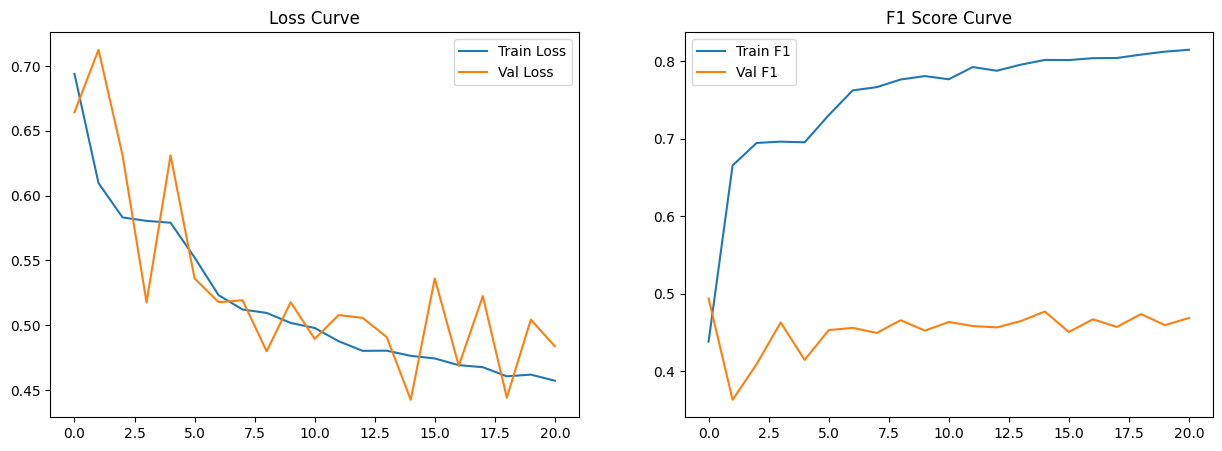

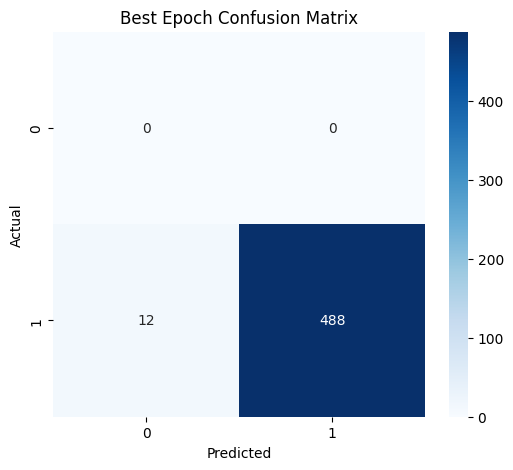

In [6]:
import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from torch.autograd import Function

# --- 1. SETUP AND HYPERPARAMETERS (From Notebook Cell 4 & 5) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 8         
EPOCHS = 30            
NUM_WORKERS = 4         
LR = 3e-4              
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True 

# Loss weights 
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# Warmup epochs and accumulation steps
WARMUP_EPOCHS = 5
EARLY_STOPPING_PATIENCE = 20
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4

# --- 2. TRANSFORMS (From Notebook Cell 6) ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- 3. DATASET HELPER FUNCTIONS (From Notebook Cell 7) ---
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    image_paths = []
    labels = []
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            try:
                label = int(parts[1])
            except ValueError:
                continue
                
            label = 1 if label == 1 else 0
            image_full_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels

# --- 4. MULTIDATASET CLASS (From Notebook Cell 7) ---
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                self.samples.append((img_path, label)) 
        
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}. Please ensure all Kaggle input datasets are mounted.")

            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            lbl = 1 if lbl == 1 else 0
            base_fname = os.path.basename(fname)  

            found = False
            search_subs = [
                "", "Image", "Imgs", "images", "JPEGImages", "img", 
                "Images/Train", "Images/Test",
            ]
            
            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        img_path = sample[0]
        lbl = sample[1]
        
        if len(sample) == 3:
            rdir = sample[2]
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))
            
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
            
        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

# --- 5. BACKBONE EXTRACTORS (From Notebook Cell 9) ---

# class DenseNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         for name, layer in self.features._modules.items():
#             x = layer(x)
#             if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
#                 feats.append(x)
#         return feats
# --- 1. Update Dimensions ---
# --- 5. INCEPTION EXTRACTOR ---
 # Required for InceptionV3
# --- 5. INCEPTION EXTRACTOR (Corrected) ---
class InceptionV3Extractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # InceptionV3 requires aux_logits=True when using pretrained weights
        self.base = models.inception_v3(weights='IMAGENET1K_V1' if pretrained else None, aux_logits=True)
        
    def forward(self, x):
        # Handle the specific layers of InceptionV3
        # We manually pass through the layers to get the final feature map
        x = self.base.Conv2d_1a_3x3(x)
        x = self.base.Conv2d_2a_3x3(x)
        x = self.base.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.base.Conv2d_3b_1x1(x)
        x = self.base.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.base.Mixed_5b(x)
        x = self.base.Mixed_5c(x)
        x = self.base.Mixed_5d(x)
        x = self.base.Mixed_6a(x)
        x = self.base.Mixed_6b(x)
        x = self.base.Mixed_6c(x)
        x = self.base.Mixed_6d(x)
        x = self.base.Mixed_6e(x)
        x = self.base.Mixed_7a(x)
        x = self.base.Mixed_7b(x)
        x = self.base.Mixed_7c(x)
        return [x]

# --- 6. INCEPTION MODEL ---
IMG_SIZE = 299 # Required for InceptionV3
INCEPTION_CHANNELS = 2048 

class InceptionOnlyModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = InceptionV3Extractor(pretrained=True)
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(INCEPTION_CHANNELS, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        feats = self.backbone(x)[-1]
        feat = self.global_pool(feats).view(x.size(0), -1)
        logits = self.classifier(feat)
        return {"logits": logits, "seg": torch.randn(x.size(0), 1, 299, 299).to(x.device)}
# class MobileNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         out = x
#         for i, layer in enumerate(self.features):
#             out = layer(out)
#             if i in (2,5,9,12):
#                 feats.append(out)
#         if len(feats) < 4:
#             feats.append(out)
#         return feats

# --- 6. USER'S Keras-Style Fusion Model (Corrected) ---

# DENSE_CHANNELS = 1920
# # CORRECTION: The actual output features are 112, resulting in 2032 total features (1920+112). 
# # We MUST use 112 here to resolve the mat1 and mat2 dimension mismatch error (2032 vs 3200).
# # MOBILE_CHANNELS = 112 
# # TOTAL_FEATURES = DENSE_CHANNELS + MOBILE_CHANNELS # 1920 + 112 = 2032
# NUM_CLASSES = 2 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize history
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}
best_val_preds = []
best_val_labels = []
class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
supcon_loss_fn = SupConLoss(temperature=0.07)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)


# --- 8. DATA AUGMENTATION HELPERS (From Notebook Cell 20) ---

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted


# --- 9. DATA LOADING SETUP (From Notebook Cell 8) ---
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"

# --- MOCKING DATASET LOADING FOR RUNNABILITY ---
try:
# --- Scenario 1 Changes ---
# 1. 80/20 Split of testing-dataset remains the same
    testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        testing_image_paths, testing_labels, test_size=0.2, random_state=SEED
    )
    ALL_ROOT_DIRS = [
        train_dir_cod,       
        test_dir_cod,       
        train_dir_camo_cam,  
        train_dir_camo_noncam
    ]
# 2. Training includes basic sets + 80% of testing-dataset
    # --- Scenario 2 Changes ---
# 1. Training includes basic sets + 80% of testing-dataset
    ALL_TRAIN_TXTS = [
        train_cam_txt, train_noncam_txt,
        train_cam_txt2, train_noncam_txt2,
    ]# 2. Validation uses CAMO-COCO test text files ONLY
    ALL_VAL_TXTS = [test_cam_txt2, test_noncam_txt2]

    train_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_TRAIN_TXTS,
        testing_image_paths=train_paths, testing_labels=train_labels,
        weak_transform=weak_tf, strong_transform=strong_tf, use_masks=USE_SEGMENTATION
    )
    val_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_VAL_TXTS,
        testing_image_paths=None, testing_labels=None,
        weak_transform=val_tf, strong_transform=None, use_masks=USE_SEGMENTATION
    )
    def build_weighted_sampler(dataset):
        labels = [sample[1] for sample in dataset.samples]  
        counts = Counter(labels)
        total = len(labels)
        if len(counts) <= 1:
            weights = [1.0] * total
        else:
            class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
            weights = [class_weights[lbl] for lbl in labels]
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_sampler = build_weighted_sampler(train_ds)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

except RuntimeError as e:
    print(f"⚠️ Warning: Cannot access Kaggle paths ({e}). Using Mock DataLoaders for demonstration.")
    
    class MockDataset(Dataset):
        def __init__(self, num_samples, num_classes=2, img_size=IMG_SIZE):
            self.num_samples = num_samples
            self.data = torch.randn(num_samples, 3, img_size, img_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))
            self.masks = torch.randint(0, 2, (num_samples, 1, img_size, img_size)).float()

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx].clone(), self.labels[idx], self.masks[idx]

    train_ds = MockDataset(num_samples=14150) 
    val_ds = MockDataset(num_samples=6606)   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Mock DataLoaders initialized with {len(train_ds)} train and {len(val_ds)} val samples.")


# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP (From Notebook Cell 20) ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP ---
# --- 10. MODEL INSTANTIATION ---
model = InceptionOnlyModel().to(device)
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        progress = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return LambdaLR(optimizer, lr_lambda)

backbone_params = [p for n, p in model.named_parameters() if 'backbone' in n]
head_params = [p for n, p in model.named_parameters() if 'classifier' in n]

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.2},
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)

# This now works because the function is defined above
scheduler = get_cosine_with_warmup_scheduler(
    opt,
    warmup_epochs=WARMUP_EPOCHS,
    total_epochs=EPOCHS
)

scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

print(f"\nModel instantiated (InceptionV3). Image Size: {IMG_SIZE}")


# --- 11. TRAINING LOOP (Adapted from Notebook Cell 21) ---

def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        y_a, y_b, lam = mix_info
        if use_focal:
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

best_vf1 = 0.0
best_epoch = 0
patience_count = 0

for epoch in range(1, EPOCHS + 1):
    # --- Updated Freeze/Unfreeze Logic for DenseNet ---
    if epoch <= FREEZE_EPOCHS:
        for name, p in model.named_parameters():
            if 'densenet_base' in name:
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        print(f"\n--- [Epoch {epoch}] Unfreezing DenseNet backbone for fine-tuning ---")
        for p in model.parameters():
            p.requires_grad = True

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # Using weak_imgs as the primary input
        imgs = weak_imgs

        # Apply Mixup or CutMix augmentation
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        # Forward pass with Automatic Mixed Precision
        with torch.amp.autocast(device_type=device if "cuda" in device else "cpu", enabled=(device=="cuda")):
            out = model(imgs) 
            logits = out["logits"]
            
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # Auxiliary components (kept at 0 for classification focus)
            seg_loss = 0.0
            supcon_loss = 0.0 
            cons_loss = 0.0   
            dom_loss = 0.0

            total_loss = clf_loss + (GAMMA_SEG * seg_loss) + (BETA_SUPCON * supcon_loss)
            total_loss = total_loss / ACCUMULATION_STEPS 

        scaler.scale(total_loss).backward()

        # Gradient Accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() 

        running_loss += total_loss.item() * ACCUMULATION_STEPS
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate training metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} F1: {f1:.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)
            logits = out["logits"]
            
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    # Calculate validation metrics
    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Val-F1: {vf1:.4f}")
    history['train_loss'].append(running_loss/max(1,n_batches))
    history['train_f1'].append(f1)
    history['val_loss'].append(val_loss/max(1,len(val_loader)))
    history['val_f1'].append(vf1)
    # Checkpointing and Early Stopping
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_val_preds = val_y_pred
        best_val_labels = val_y_true
        best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"⭐ New Best Model Saved (Val F1: {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
            break

print(f"\nTraining complete. Best Val F1: {best_vf1:.4f} at Epoch {best_epoch}")

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    
    # F1 Curve
    ax2.plot(history['train_f1'], label='Train F1')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_title('F1 Score Curve')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Epoch Confusion Matrix')
    plt.show()

# Call these after training finishes
plot_history(history)
plot_confusion_matrix(best_val_labels, best_val_preds)

Densenet201

Device: cuda
✅ Loaded 14604 samples from 4 root directories.
✅ Loaded 500 samples from 4 root directories.
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 189MB/s]
/tmp/ipykernel_24/1546513321.py:592: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))



Model instantiated (DenseNet201 Only). LR: 0.0003, Epochs: 30.


Train 1/30: 100%|██████████| 1826/1826 [02:58<00:00, 10.23it/s]

[Epoch 1] Train Loss: 0.6952 Acc: 0.5034 F1: 0.3349


[Epoch 1] Val Loss: 0.6415 Acc: 1.0000 Val-F1: 1.0000
⭐ New Best Model Saved (Val F1: 1.0000)


Train 2/30: 100%|██████████| 1826/1826 [03:01<00:00, 10.07it/s]


[Epoch 2] Train Loss: 0.6009 Acc: 0.6837 F1: 0.6817
[Epoch 2] Val Loss: 0.7767 Acc: 0.5820 Val-F1: 0.3679


Train 3/30: 100%|██████████| 1826/1826 [02:58<00:00, 10.25it/s]

[Epoch 3] Train Loss: 0.5563 Acc: 0.7321 F1: 0.7319


[Epoch 3] Val Loss: 0.7865 Acc: 0.5860 Val-F1: 0.3695


Train 4/30: 100%|██████████| 1826/1826 [03:01<00:00, 10.06it/s]


[Epoch 4] Train Loss: 0.5452 Acc: 0.7379 F1: 0.7378
[Epoch 4] Val Loss: 0.4405 Acc: 0.8980 Val-F1: 0.4731


Train 5/30: 100%|██████████| 1826/1826 [03:00<00:00, 10.10it/s]

[Epoch 5] Train Loss: 0.5416 Acc: 0.7397 F1: 0.7395


[Epoch 5] Val Loss: 0.4894 Acc: 0.8560 Val-F1: 0.4612

--- [Epoch 6] Unfreezing DenseNet backbone for fine-tuning ---


Train 6/30: 100%|██████████| 1826/1826 [05:02<00:00,  6.03it/s]

[Epoch 6] Train Loss: 0.5262 Acc: 0.7565 F1: 0.7565


[Epoch 6] Val Loss: 0.4787 Acc: 0.8680 Val-F1: 0.4647


Train 7/30: 100%|██████████| 1826/1826 [05:06<00:00,  5.96it/s]

[Epoch 7] Train Loss: 0.4987 Acc: 0.7786 F1: 0.7783


[Epoch 7] Val Loss: 0.4935 Acc: 0.8760 Val-F1: 0.4670


Train 8/30: 100%|██████████| 1826/1826 [05:04<00:00,  5.99it/s]

[Epoch 8] Train Loss: 0.4856 Acc: 0.7973 F1: 0.7973


[Epoch 8] Val Loss: 0.5383 Acc: 0.8120 Val-F1: 0.4481


Train 9/30: 100%|██████████| 1826/1826 [05:05<00:00,  5.98it/s]

[Epoch 9] Train Loss: 0.4825 Acc: 0.7998 F1: 0.7998


[Epoch 9] Val Loss: 0.4655 Acc: 0.8760 Val-F1: 0.4670


Train 10/30: 100%|██████████| 1826/1826 [05:04<00:00,  6.00it/s]

[Epoch 10] Train Loss: 0.4742 Acc: 0.7982 F1: 0.7982


[Epoch 10] Val Loss: 0.5276 Acc: 0.8240 Val-F1: 0.4518


Train 11/30: 100%|██████████| 1826/1826 [05:03<00:00,  6.01it/s]

[Epoch 11] Train Loss: 0.4696 Acc: 0.8011 F1: 0.8011


[Epoch 11] Val Loss: 0.4438 Acc: 0.8780 Val-F1: 0.4675


Train 12/30: 100%|██████████| 1826/1826 [05:01<00:00,  6.06it/s]

[Epoch 12] Train Loss: 0.4668 Acc: 0.8100 F1: 0.8100


[Epoch 12] Val Loss: 0.4598 Acc: 0.8820 Val-F1: 0.4687


Train 13/30: 100%|██████████| 1826/1826 [05:03<00:00,  6.02it/s]

[Epoch 13] Train Loss: 0.4604 Acc: 0.8056 F1: 0.8056


[Epoch 13] Val Loss: 0.4303 Acc: 0.8940 Val-F1: 0.4720


Train 14/30: 100%|██████████| 1826/1826 [05:03<00:00,  6.01it/s]

[Epoch 14] Train Loss: 0.4534 Acc: 0.8127 F1: 0.8127


[Epoch 14] Val Loss: 0.4847 Acc: 0.8620 Val-F1: 0.4629


Train 15/30: 100%|██████████| 1826/1826 [05:02<00:00,  6.03it/s]

[Epoch 15] Train Loss: 0.4528 Acc: 0.8228 F1: 0.8228


[Epoch 15] Val Loss: 0.4726 Acc: 0.8760 Val-F1: 0.4670


Train 16/30: 100%|██████████| 1826/1826 [05:06<00:00,  5.96it/s]

[Epoch 16] Train Loss: 0.4486 Acc: 0.8182 F1: 0.8182


[Epoch 16] Val Loss: 0.5311 Acc: 0.8200 Val-F1: 0.4505


Train 17/30: 100%|██████████| 1826/1826 [05:05<00:00,  5.97it/s]

[Epoch 17] Train Loss: 0.4450 Acc: 0.8268 F1: 0.8268


[Epoch 17] Val Loss: 0.5017 Acc: 0.8660 Val-F1: 0.4641


Train 18/30: 100%|██████████| 1826/1826 [05:07<00:00,  5.93it/s]

[Epoch 18] Train Loss: 0.4461 Acc: 0.8141 F1: 0.8141


[Epoch 18] Val Loss: 0.4668 Acc: 0.8880 Val-F1: 0.4703


Train 19/30: 100%|██████████| 1826/1826 [05:03<00:00,  6.01it/s]

[Epoch 19] Train Loss: 0.4398 Acc: 0.8227 F1: 0.8227


[Epoch 19] Val Loss: 0.4710 Acc: 0.8840 Val-F1: 0.4692


Train 20/30: 100%|██████████| 1826/1826 [05:05<00:00,  5.98it/s]

[Epoch 20] Train Loss: 0.4428 Acc: 0.8308 F1: 0.8308


[Epoch 20] Val Loss: 0.4288 Acc: 0.9180 Val-F1: 0.4786


Train 21/30: 100%|██████████| 1826/1826 [05:05<00:00,  5.98it/s]

[Epoch 21] Train Loss: 0.4373 Acc: 0.8269 F1: 0.8269


[Epoch 21] Val Loss: 0.4611 Acc: 0.8920 Val-F1: 0.4715
Early stopping triggered after 20 epochs of no improvement.

Training complete. Best Val F1: 1.0000 at Epoch 1


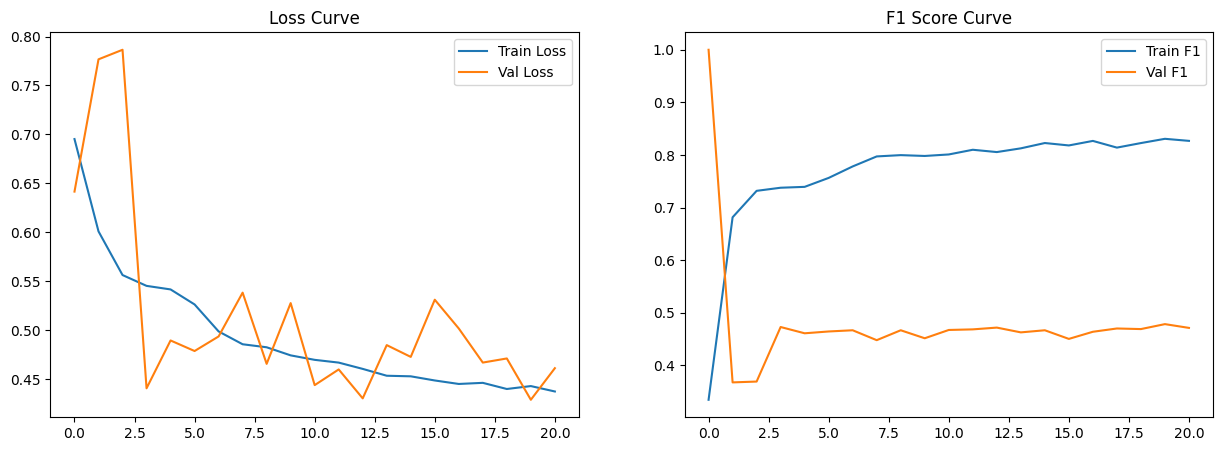

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


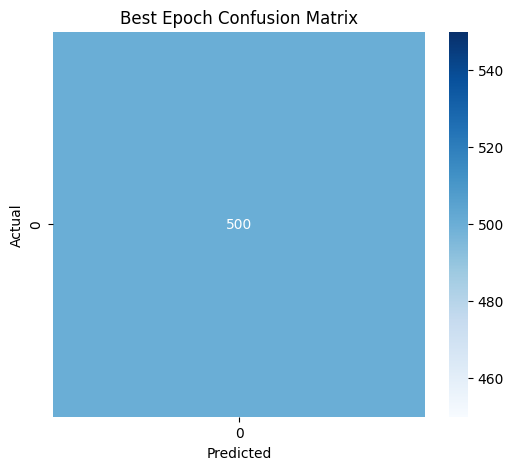

In [7]:

import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from torch.autograd import Function

# --- 1. SETUP AND HYPERPARAMETERS (From Notebook Cell 4 & 5) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 8         
EPOCHS = 30            
NUM_WORKERS = 4         
LR = 3e-4              
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True 

# Loss weights 
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# Warmup epochs and accumulation steps
WARMUP_EPOCHS = 5
EARLY_STOPPING_PATIENCE = 20
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}
best_val_preds = []
best_val_labels = []
# --- 2. TRANSFORMS (From Notebook Cell 6) ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- 3. DATASET HELPER FUNCTIONS (From Notebook Cell 7) ---
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    image_paths = []
    labels = []
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            try:
                label = int(parts[1])
            except ValueError:
                continue
                
            label = 1 if label == 1 else 0
            image_full_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels

# --- 4. MULTIDATASET CLASS (From Notebook Cell 7) ---
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                self.samples.append((img_path, label)) 
        
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}. Please ensure all Kaggle input datasets are mounted.")

            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            lbl = 1 if lbl == 1 else 0
            base_fname = os.path.basename(fname)  

            found = False
            search_subs = [
                "", "Image", "Imgs", "images", "JPEGImages", "img", 
                "Images/Train", "Images/Test",
            ]
            
            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        img_path = sample[0]
        lbl = sample[1]
        
        if len(sample) == 3:
            rdir = sample[2]
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))
            
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
            
        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

# --- 5. BACKBONE EXTRACTORS (From Notebook Cell 9) ---

# class DenseNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         for name, layer in self.features._modules.items():
#             x = layer(x)
#             if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
#                 feats.append(x)
#         return feats
# --- 1. Update Dimensions ---
DENSE_CHANNELS = 1920  # The output of DenseNet201's last features layer
NUM_CLASSES = 2 
class DenseNetExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
    def forward(self, x):
        feats = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
                feats.append(x)
        return feats
# --- 2. DenseNet Only Model ---
class DenseNetOnly(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dense_out_channels=DENSE_CHANNELS):
        super().__init__()
        
        # Keep only DenseNet
        self.densenet_base = DenseNetExtractor(pretrained=True)
        
        # Freeze DenseNet initially
        for param in self.densenet_base.parameters():
            param.requires_grad = False
            
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier now takes ONLY DenseNet features (1920)
        self.classifier = nn.Sequential(
            nn.Linear(dense_out_channels, 512), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) 
        )
        
        # Keep these for training loop compatibility
        self.use_seg = False 
        self.domain_head = nn.Identity()
        
    def forward(self, x, grl_lambda=0.0):
        # 1. Feature Extraction
        densenet_feats = self.densenet_base(x)[-1]
        
        # 2. Global Pooling
        # Shape change: [Batch, 1920, 7, 7] -> [Batch, 1920]
        feat = self.global_pool(densenet_feats).view(x.size(0), -1)

        # 3. Classification
        logits = self.classifier(feat)
        
        # Return same dictionary structure so Training Loop doesn't break
        return {
            "logits": logits, 
            "feat": feat,
            "domain_logits": torch.randn(x.size(0), 2).to(x.device), 
            "seg": torch.randn(x.size(0), 1, x.size(-2), x.size(-1)).to(x.device)
        }

# class MobileNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         out = x
#         for i, layer in enumerate(self.features):
#             out = layer(out)
#             if i in (2,5,9,12):
#                 feats.append(out)
#         if len(feats) < 4:
#             feats.append(out)
#         return feats

# --- 6. USER'S Keras-Style Fusion Model (Corrected) ---

DENSE_CHANNELS = 1920
# CORRECTION: The actual output features are 112, resulting in 2032 total features (1920+112). 
# We MUST use 112 here to resolve the mat1 and mat2 dimension mismatch error (2032 vs 3200).
# MOBILE_CHANNELS = 112 
# TOTAL_FEATURES = DENSE_CHANNELS + MOBILE_CHANNELS # 1920 + 112 = 2032
NUM_CLASSES = 2 


class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
supcon_loss_fn = SupConLoss(temperature=0.07)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)


# --- 8. DATA AUGMENTATION HELPERS (From Notebook Cell 20) ---

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted


# --- 9. DATA LOADING SETUP (From Notebook Cell 8) ---
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"

# --- MOCKING DATASET LOADING FOR RUNNABILITY ---
try:
# --- Scenario 1 Changes ---
# 1. 80/20 Split of testing-dataset remains the same
    testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        testing_image_paths, testing_labels, test_size=0.2, random_state=SEED
    )
    ALL_ROOT_DIRS = [
        train_dir_cod,       
        test_dir_cod,       
        train_dir_camo_cam,  
        train_dir_camo_noncam
    ]
# 2. Training includes basic sets + 80% of testing-dataset
    # --- Scenario 2 Changes ---
# 1. Training includes basic sets + 80% of testing-dataset
    ALL_TRAIN_TXTS = [
        train_cam_txt, train_noncam_txt,
        train_cam_txt2, train_noncam_txt2,
    ]# 2. Validation uses CAMO-COCO test text files ONLY
    ALL_VAL_TXTS = [test_cam_txt2, test_noncam_txt2]

    train_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_TRAIN_TXTS,
        testing_image_paths=train_paths, testing_labels=train_labels,
        weak_transform=weak_tf, strong_transform=strong_tf, use_masks=USE_SEGMENTATION
    )
    val_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_VAL_TXTS,
        testing_image_paths=None, testing_labels=None,
        weak_transform=val_tf, strong_transform=None, use_masks=USE_SEGMENTATION
    )
    def build_weighted_sampler(dataset):
        labels = [sample[1] for sample in dataset.samples]  
        counts = Counter(labels)
        total = len(labels)
        if len(counts) <= 1:
            weights = [1.0] * total
        else:
            class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
            weights = [class_weights[lbl] for lbl in labels]
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_sampler = build_weighted_sampler(train_ds)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

except RuntimeError as e:
    print(f"⚠️ Warning: Cannot access Kaggle paths ({e}). Using Mock DataLoaders for demonstration.")
    
    class MockDataset(Dataset):
        def __init__(self, num_samples, num_classes=2, img_size=IMG_SIZE):
            self.num_samples = num_samples
            self.data = torch.randn(num_samples, 3, img_size, img_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))
            self.masks = torch.randint(0, 2, (num_samples, 1, img_size, img_size)).float()

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx].clone(), self.labels[idx], self.masks[idx]

    train_ds = MockDataset(num_samples=14150) 
    val_ds = MockDataset(num_samples=6606)   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Mock DataLoaders initialized with {len(train_ds)} train and {len(val_ds)} val samples.")


# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP (From Notebook Cell 20) ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP ---
model = DenseNetOnly().to(device)

backbone_params = []
head_params = []
for name, param in model.named_parameters():
    # Only search for densenet_base; mobilenet_base is gone
    if 'densenet_base' in name:
        backbone_params.append(param)
    else:
        head_params.append(param)

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.2}, 
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)

from torch.optim.lr_scheduler import LambdaLR

def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        progress = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return LambdaLR(optimizer, lr_lambda)

# Keep your scheduler, scaler, and print statements as they are
scheduler = get_cosine_with_warmup_scheduler(
    opt,
    warmup_epochs=WARMUP_EPOCHS,
    total_epochs=EPOCHS
)

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

print(f"\nModel instantiated (DenseNet201 Only). LR: {LR}, Epochs: {EPOCHS}.")

# --- 11. TRAINING LOOP (Adapted from Notebook Cell 21) ---
def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        y_a, y_b, lam = mix_info
        if use_focal:
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

best_vf1 = 0.0
best_epoch = 0
patience_count = 0

for epoch in range(1, EPOCHS + 1):
    # --- Updated Freeze/Unfreeze Logic for DenseNet ---
    if epoch <= FREEZE_EPOCHS:
        for name, p in model.named_parameters():
            if 'densenet_base' in name:
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        print(f"\n--- [Epoch {epoch}] Unfreezing DenseNet backbone for fine-tuning ---")
        for p in model.parameters():
            p.requires_grad = True

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # Using weak_imgs as the primary input
        imgs = weak_imgs

        # Apply Mixup or CutMix augmentation
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        # Forward pass with Automatic Mixed Precision
        with torch.amp.autocast(device_type=device if "cuda" in device else "cpu", enabled=(device=="cuda")):
            out = model(imgs) 
            logits = out["logits"]
            
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # Auxiliary components (kept at 0 for classification focus)
            seg_loss = 0.0
            supcon_loss = 0.0 
            cons_loss = 0.0   
            dom_loss = 0.0

            total_loss = clf_loss + (GAMMA_SEG * seg_loss) + (BETA_SUPCON * supcon_loss)
            total_loss = total_loss / ACCUMULATION_STEPS 

        scaler.scale(total_loss).backward()

        # Gradient Accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() 

        running_loss += total_loss.item() * ACCUMULATION_STEPS
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate training metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} F1: {f1:.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)
            logits = out["logits"]
            
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    # Calculate validation metrics
    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Val-F1: {vf1:.4f}")
    history['train_loss'].append(running_loss/max(1,n_batches))
    history['train_f1'].append(f1)
    history['val_loss'].append(val_loss/max(1,len(val_loader)))
    history['val_f1'].append(vf1)
    # Checkpointing and Early Stopping
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_val_preds = val_y_pred
        best_val_labels = val_y_true
        # best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"⭐ New Best Model Saved (Val F1: {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
            break

print(f"\nTraining complete. Best Val F1: {best_vf1:.4f} at Epoch {best_epoch}")

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    
    # F1 Curve
    ax2.plot(history['train_f1'], label='Train F1')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_title('F1 Score Curve')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Epoch Confusion Matrix')
    plt.show()

# Call these after training finishes
plot_history(history)
plot_confusion_matrix(best_val_labels, best_val_preds)

Device: cuda
✅ Loaded 14604 samples from 4 root directories.
✅ Loaded 500 samples from 4 root directories.
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 170MB/s]
/tmp/ipykernel_24/3086065517.py:586: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))



Model instantiated (DenseNet201 Only). LR: 0.0003, Epochs: 30.


Train 1/30: 100%|██████████| 1826/1826 [02:55<00:00, 10.39it/s]


[Epoch 1] Train Loss: 0.6936 Acc: 0.5048 F1: 0.3373
[Epoch 1] Val Loss: 0.7146 Acc: 0.0000 Val-F1: 0.0000


Train 2/30: 100%|██████████| 1826/1826 [02:56<00:00, 10.32it/s]

[Epoch 2] Train Loss: 0.5984 Acc: 0.6904 F1: 0.6903


[Epoch 2] Val Loss: 0.6196 Acc: 0.7020 Val-F1: 0.4125
⭐ New Best Model Saved (Val F1: 0.4125)


Train 3/30: 100%|██████████| 1826/1826 [02:55<00:00, 10.40it/s]

[Epoch 3] Train Loss: 0.5511 Acc: 0.7310 F1: 0.7309


[Epoch 3] Val Loss: 0.5173 Acc: 0.8280 Val-F1: 0.4530
⭐ New Best Model Saved (Val F1: 0.4530)


Train 4/30: 100%|██████████| 1826/1826 [02:56<00:00, 10.33it/s]


[Epoch 4] Train Loss: 0.5394 Acc: 0.7416 F1: 0.7416
[Epoch 4] Val Loss: 0.4317 Acc: 0.9000 Val-F1: 0.4737
⭐ New Best Model Saved (Val F1: 0.4737)


Train 5/30: 100%|██████████| 1826/1826 [03:01<00:00, 10.05it/s]

[Epoch 5] Train Loss: 0.5363 Acc: 0.7436 F1: 0.7435


[Epoch 5] Val Loss: 0.4913 Acc: 0.8500 Val-F1: 0.4595

--- [Epoch 6] Unfreezing DenseNet backbone for fine-tuning ---


Train 6/30: 100%|██████████| 1826/1826 [04:31<00:00,  6.72it/s]


[Epoch 6] Train Loss: 0.5183 Acc: 0.7678 F1: 0.7675
[Epoch 6] Val Loss: 0.3975 Acc: 0.9440 Val-F1: 0.4856
⭐ New Best Model Saved (Val F1: 0.4856)


Train 7/30: 100%|██████████| 1826/1826 [04:28<00:00,  6.79it/s]

[Epoch 7] Train Loss: 0.5004 Acc: 0.7792 F1: 0.7792


[Epoch 7] Val Loss: 0.4973 Acc: 0.8600 Val-F1: 0.4624


Train 8/30: 100%|██████████| 1826/1826 [04:26<00:00,  6.84it/s]


[Epoch 8] Train Loss: 0.4881 Acc: 0.7914 F1: 0.7914
[Epoch 8] Val Loss: 0.4108 Acc: 0.9240 Val-F1: 0.4802


Train 9/30: 100%|██████████| 1826/1826 [04:29<00:00,  6.77it/s]


[Epoch 9] Train Loss: 0.4835 Acc: 0.7968 F1: 0.7967
[Epoch 9] Val Loss: 0.4439 Acc: 0.8900 Val-F1: 0.4709


Train 10/30: 100%|██████████| 1826/1826 [04:31<00:00,  6.72it/s]


[Epoch 10] Train Loss: 0.4792 Acc: 0.7966 F1: 0.7965
[Epoch 10] Val Loss: 0.4896 Acc: 0.8420 Val-F1: 0.4571


Train 11/30: 100%|██████████| 1826/1826 [04:30<00:00,  6.75it/s]


[Epoch 11] Train Loss: 0.4725 Acc: 0.7966 F1: 0.7965
[Epoch 11] Val Loss: 0.4452 Acc: 0.9000 Val-F1: 0.4737


Train 12/30: 100%|██████████| 1826/1826 [04:29<00:00,  6.77it/s]

[Epoch 12] Train Loss: 0.4697 Acc: 0.8070 F1: 0.8070


[Epoch 12] Val Loss: 0.4425 Acc: 0.9000 Val-F1: 0.4737


Train 13/30: 100%|██████████| 1826/1826 [04:27<00:00,  6.82it/s]


[Epoch 13] Train Loss: 0.4668 Acc: 0.7985 F1: 0.7985
[Epoch 13] Val Loss: 0.4660 Acc: 0.8800 Val-F1: 0.4681


Train 14/30: 100%|██████████| 1826/1826 [04:29<00:00,  6.77it/s]


[Epoch 14] Train Loss: 0.4590 Acc: 0.8061 F1: 0.8061
[Epoch 14] Val Loss: 0.4604 Acc: 0.8860 Val-F1: 0.4698


Train 15/30: 100%|██████████| 1826/1826 [04:31<00:00,  6.73it/s]


[Epoch 15] Train Loss: 0.4550 Acc: 0.8220 F1: 0.8220
[Epoch 15] Val Loss: 0.4175 Acc: 0.9280 Val-F1: 0.4813


Train 16/30: 100%|██████████| 1826/1826 [04:29<00:00,  6.78it/s]


[Epoch 16] Train Loss: 0.4531 Acc: 0.8164 F1: 0.8164
[Epoch 16] Val Loss: 0.4451 Acc: 0.9020 Val-F1: 0.4742


Train 17/30: 100%|██████████| 1826/1826 [04:26<00:00,  6.84it/s]


[Epoch 17] Train Loss: 0.4481 Acc: 0.8250 F1: 0.8250
[Epoch 17] Val Loss: 0.4441 Acc: 0.9020 Val-F1: 0.4742


Train 18/30: 100%|██████████| 1826/1826 [04:30<00:00,  6.76it/s]


[Epoch 18] Train Loss: 0.4488 Acc: 0.8105 F1: 0.8104
[Epoch 18] Val Loss: 0.4019 Acc: 0.9460 Val-F1: 0.4861
⭐ New Best Model Saved (Val F1: 0.4861)


Train 19/30: 100%|██████████| 1826/1826 [04:30<00:00,  6.75it/s]


[Epoch 19] Train Loss: 0.4437 Acc: 0.8282 F1: 0.8282
[Epoch 19] Val Loss: 0.4622 Acc: 0.9000 Val-F1: 0.4737


Train 20/30: 100%|██████████| 1826/1826 [04:28<00:00,  6.81it/s]

[Epoch 20] Train Loss: 0.4441 Acc: 0.8319 F1: 0.8319


[Epoch 20] Val Loss: 0.4348 Acc: 0.9100 Val-F1: 0.4764


Train 21/30: 100%|██████████| 1826/1826 [04:29<00:00,  6.76it/s]


[Epoch 21] Train Loss: 0.4397 Acc: 0.8309 F1: 0.8308
[Epoch 21] Val Loss: 0.4764 Acc: 0.8840 Val-F1: 0.4692


Train 22/30: 100%|██████████| 1826/1826 [04:33<00:00,  6.67it/s]


[Epoch 22] Train Loss: 0.4400 Acc: 0.8258 F1: 0.8258
[Epoch 22] Val Loss: 0.4331 Acc: 0.9080 Val-F1: 0.4759


Train 23/30: 100%|██████████| 1826/1826 [04:32<00:00,  6.70it/s]


[Epoch 23] Train Loss: 0.4374 Acc: 0.8273 F1: 0.8273
[Epoch 23] Val Loss: 0.4231 Acc: 0.9260 Val-F1: 0.4808


Train 24/30: 100%|██████████| 1826/1826 [04:33<00:00,  6.68it/s]

[Epoch 24] Train Loss: 0.4405 Acc: 0.8263 F1: 0.8263


[Epoch 24] Val Loss: 0.4417 Acc: 0.9000 Val-F1: 0.4737


Train 25/30: 100%|██████████| 1826/1826 [04:32<00:00,  6.71it/s]


[Epoch 25] Train Loss: 0.4363 Acc: 0.8311 F1: 0.8311
[Epoch 25] Val Loss: 0.4248 Acc: 0.9220 Val-F1: 0.4797


Train 26/30: 100%|██████████| 1826/1826 [04:32<00:00,  6.69it/s]


[Epoch 26] Train Loss: 0.4356 Acc: 0.8338 F1: 0.8338
[Epoch 26] Val Loss: 0.4332 Acc: 0.9100 Val-F1: 0.4764


Train 27/30: 100%|██████████| 1826/1826 [04:33<00:00,  6.68it/s]


[Epoch 27] Train Loss: 0.4363 Acc: 0.8320 F1: 0.8319
[Epoch 27] Val Loss: 0.4267 Acc: 0.9160 Val-F1: 0.4781


Train 28/30: 100%|██████████| 1826/1826 [04:31<00:00,  6.74it/s]

[Epoch 28] Train Loss: 0.4371 Acc: 0.8328 F1: 0.8328


[Epoch 28] Val Loss: 0.4387 Acc: 0.9120 Val-F1: 0.4770


Train 29/30: 100%|██████████| 1826/1826 [04:26<00:00,  6.84it/s]

[Epoch 29] Train Loss: 0.4378 Acc: 0.8346 F1: 0.8346


[Epoch 29] Val Loss: 0.4255 Acc: 0.9220 Val-F1: 0.4797


Train 30/30: 100%|██████████| 1826/1826 [04:25<00:00,  6.88it/s]

[Epoch 30] Train Loss: 0.4348 Acc: 0.8317 F1: 0.8317


[Epoch 30] Val Loss: 0.4276 Acc: 0.9220 Val-F1: 0.4797

Training complete. Best Val F1: 0.4861 at Epoch 18


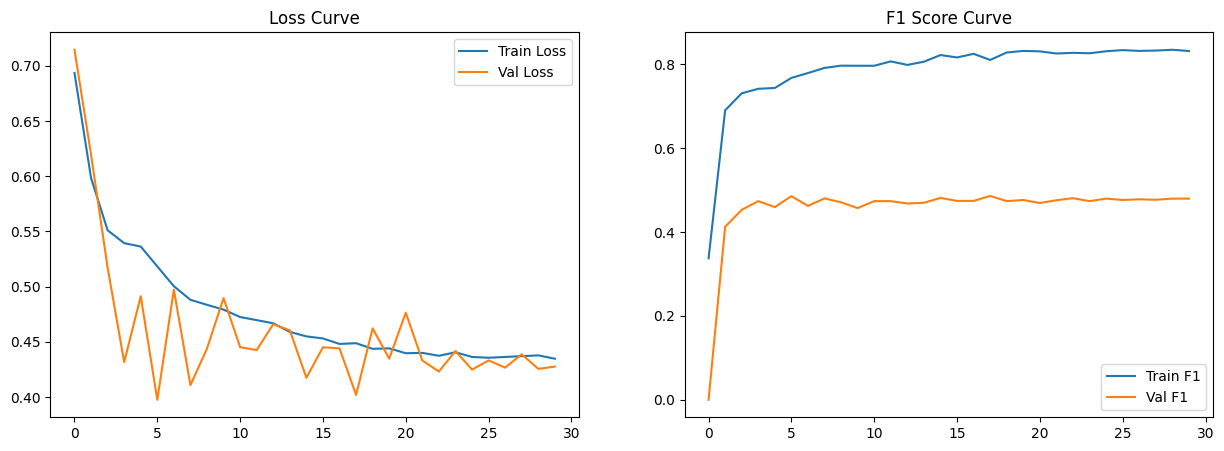

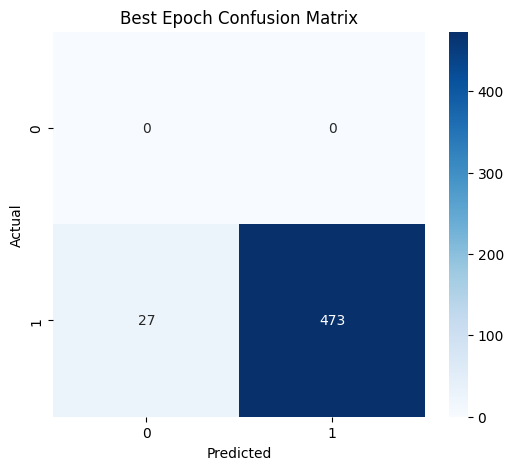

In [8]:
import os, random, math, time
from pathlib import Path
from tqdm import tqdm
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import RandAugment
import timm 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from collections import Counter
from torch.autograd import Function

# --- 1. SETUP AND HYPERPARAMETERS (From Notebook Cell 4 & 5) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda": torch.cuda.manual_seed_all(SEED)

IMG_SIZE = 224
BATCH_SIZE = 8         
EPOCHS = 30            
NUM_WORKERS = 4         
LR = 3e-4              
LABEL_SMOOTH = 0.1
SAVE_PATH = "best_model.pth"
USE_SEGMENTATION = True 

# Loss weights 
ALPHA_DOM = 0.5
BETA_SUPCON = 0.3
ETA_CONS = 0.1
GAMMA_SEG = 0.5

# Mixup/CutMix probabilities and alphas
PROB_MIXUP = 0.5
PROB_CUTMIX = 0.5
MIXUP_ALPHA = 0.2
CUTMIX_ALPHA = 1.0

# Warmup epochs and accumulation steps
WARMUP_EPOCHS = 5
EARLY_STOPPING_PATIENCE = 20
FREEZE_EPOCHS = 5
ACCUMULATION_STEPS = 4
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}
best_val_preds = []
best_val_labels = []
# --- 2. TRANSFORMS (From Notebook Cell 6) ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

weak_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
strong_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    RandAugment(num_ops=2, magnitude=9),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# --- 3. DATASET HELPER FUNCTIONS (From Notebook Cell 7) ---
def read_file_with_encoding(file_path, encodings=['utf-8', 'utf-8-sig', 'ISO-8859-1']):
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.readlines()
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 
    raise RuntimeError(f"Unable to read {file_path} with any of the provided encodings.")

def load_testing_dataset_info(info_file, image_dir):
    image_paths = []
    labels = []
    encodings = ['utf-8-sig', 'utf-8', 'ISO-8859-1', 'latin-1']
    lines = []
    
    for encoding in encodings:
        try:
            with open(info_file, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            pass
        except Exception as e:
            raise 

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 2:
            image_filename = parts[0]
            try:
                label = int(parts[1])
            except ValueError:
                continue
                
            label = 1 if label == 1 else 0
            image_full_path = os.path.join(image_dir, image_filename)
            image_paths.append(image_full_path)
            labels.append(label)
    
    return image_paths, labels

# --- 4. MULTIDATASET CLASS (From Notebook Cell 7) ---
class MultiDataset(Dataset):
    def __init__(self, root_dirs, txt_files, testing_image_paths=None, testing_labels=None, weak_transform=None, strong_transform=None, use_masks=True):
        self.root_dirs = root_dirs
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.use_masks = use_masks
        self.samples = []

        if testing_image_paths is not None and testing_labels is not None:
            for img_path, label in zip(testing_image_paths, testing_labels):
                self.samples.append((img_path, label)) 
        
        if isinstance(txt_files, str):
            txt_files = [txt_files]

        all_lines = []
        for t in txt_files:
            if not os.path.exists(t):
                raise RuntimeError(f"TXT file not found: {t}. Please ensure all Kaggle input datasets are mounted.")

            lines = read_file_with_encoding(t)
            all_lines.extend([(line.strip(), t) for line in lines if line.strip()])

        for line, src_txt in all_lines:
            parts = line.split()
            if len(parts) == 0:
                continue

            fname = parts[0]
            if len(parts) >= 2:
                try:
                    lbl = int(parts[1])
                except:
                    lbl = 1 if "CAM" in fname or "cam" in fname else 0
            else:
                lbl = 1 if "CAM" in fname or "cam" in fname else 0
            
            lbl = 1 if lbl == 1 else 0
            base_fname = os.path.basename(fname)  

            found = False
            search_subs = [
                "", "Image", "Imgs", "images", "JPEGImages", "img", 
                "Images/Train", "Images/Test",
            ]
            
            for rdir in self.root_dirs:
                for sub in search_subs:
                    img_path = os.path.join(rdir, sub, base_fname)
                    if os.path.exists(img_path):
                        self.samples.append((img_path, lbl, rdir))
                        found = True
                        break
                if found:
                    break

        if len(self.samples) == 0:
            raise RuntimeError(f"No valid samples found from {txt_files}")

        print(f"✅ Loaded {len(self.samples)} samples from {len(self.root_dirs)} root directories.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        global IMG_SIZE 
        
        sample = self.samples[idx]
        img_path = sample[0]
        lbl = sample[1]
        
        if len(sample) == 3:
            rdir = sample[2]
        else:
            rdir = os.path.dirname(os.path.dirname(img_path))
            
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
            
        if self.weak_transform:
            weak = self.weak_transform(img)
        else:
            weak = transforms.ToTensor()(img)
            
        if self.strong_transform:
            strong = self.strong_transform(img)
        else:
            strong = weak.clone()

        mask = None
        if self.use_masks:
            mask_name = os.path.splitext(os.path.basename(img_path))[0] + ".png"
            found_mask = False
            for mask_dir in ["GT_Object", "GT", "masks", "Mask"]:
                mask_path = os.path.join(rdir, mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    m = Image.open(mask_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
                    m = np.array(m).astype(np.float32) / 255.0
                    mask = torch.from_numpy((m > 0.5).astype(np.float32)).unsqueeze(0)
                    found_mask = True
                    break

            if mask is None:
                mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
                
        return weak, strong, lbl, mask

# --- 5. BACKBONE EXTRACTORS (From Notebook Cell 9) ---

# class DenseNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.densenet201(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         for name, layer in self.features._modules.items():
#             x = layer(x)
#             if name in ["denseblock1","denseblock2","denseblock3","denseblock4"]:
#                 feats.append(x)
#         return feats

# --- 5. BACKBONE EXTRACTOR (DenseNet169) ---
class DenseNetExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Changed from densenet201 to densenet169
        self.features = models.densenet169(weights='IMAGENET1K_V1' if pretrained else None).features
        
    def forward(self, x):
        feats = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            # Intermediate features are still valuable for multi-scale logic
            if name in ["denseblock1", "denseblock2", "denseblock3", "denseblock4"]:
                feats.append(x)
        return feats
# --- 2. DenseNet Only Model ---
# --- 6. MODEL DIMENSIONS ---
DENSE_CHANNELS = 1664  # Updated for DenseNet169
NUM_CLASSES = 2 

class DenseNetOnly(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dense_out_channels=DENSE_CHANNELS):
        super().__init__()
        self.densenet_base = DenseNetExtractor(pretrained=True)
        
        for param in self.densenet_base.parameters():
            param.requires_grad = False
            
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier input is now 1664
        self.classifier = nn.Sequential(
            nn.Linear(dense_out_channels, 512), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes) 
        )
        
        self.use_seg = False 
        self.domain_head = nn.Identity()
        
    def forward(self, x, grl_lambda=0.0):
        densenet_feats = self.densenet_base(x)[-1]
        feat = self.global_pool(densenet_feats).view(x.size(0), -1)
        logits = self.classifier(feat)
        
        return {
            "logits": logits, 
            "feat": feat,
            "domain_logits": torch.randn(x.size(0), 2).to(x.device), 
            "seg": torch.randn(x.size(0), 1, x.size(-2), x.size(-1)).to(x.device)
        }

# class MobileNetExtractor(nn.Module):
#     def __init__(self, pretrained=True):
#         super().__init__()
#         self.features = models.mobilenet_v3_large(weights='IMAGENET1K_V1' if pretrained else None).features
#     def forward(self, x):
#         feats = []
#         out = x
#         for i, layer in enumerate(self.features):
#             out = layer(out)
#             if i in (2,5,9,12):
#                 feats.append(out)
#         if len(feats) < 4:
#             feats.append(out)
#         return feats

# --- 6. USER'S Keras-Style Fusion Model (Corrected) ---

DENSE_CHANNELS = 1920
# CORRECTION: The actual output features are 112, resulting in 2032 total features (1920+112). 
# We MUST use 112 here to resolve the mat1 and mat2 dimension mismatch error (2032 vs 3200).
# MOBILE_CHANNELS = 112 
# TOTAL_FEATURES = DENSE_CHANNELS + MOBILE_CHANNELS # 1920 + 112 = 2032
NUM_CLASSES = 2 


class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.s = smoothing
    def forward(self, logits, target):
        c = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logp)
            true_dist.fill_(self.s / (c - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.s)
        return (-true_dist * logp).sum(dim=-1).mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        pt = prob.gather(1, target.unsqueeze(1)).squeeze(1)
        ce = F.cross_entropy(logits, target, reduction='none')
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    num = 2 * (pred * target).sum() + smooth
    den = pred.sum() + target.sum() + smooth
    return 1 - (num / den)

def seg_loss_fn(pred, mask):
    if pred.shape[-2:] != mask.shape[-2:]:
        pred = F.interpolate(pred, size=mask.shape[-2:], mode="bilinear", align_corners=False)
    return F.binary_cross_entropy_with_logits(pred, mask) + dice_loss(pred, mask)

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cos = nn.CosineSimilarity(dim=-1)
    def forward(self, features, labels):
        device = features.device
        f = F.normalize(features, dim=1)
        sim = torch.matmul(f, f.T) / self.temperature
        labels = labels.contiguous().view(-1,1)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_max, _ = torch.max(sim, dim=1, keepdim=True)
        logits = sim - logits_max.detach()
        exp_logits = torch.exp(logits) * (1 - torch.eye(len(features), device=device))
        denom = exp_logits.sum(1, keepdim=True)
        pos_mask = mask - torch.eye(len(features), device=device)
        pos_exp = (exp_logits * pos_mask).sum(1)
        loss = -torch.log((pos_exp + 1e-8) / (denom + 1e-8) + 1e-12)
        valid = (pos_mask.sum(1) > 0).float()
        loss = (loss * valid).sum() / (valid.sum() + 1e-8)
        return loss

clf_loss_ce = LabelSmoothingCE(LABEL_SMOOTH)
clf_loss_focal = FocalLoss(gamma=1.5)
supcon_loss_fn = SupConLoss(temperature=0.07)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, l):
        ctx.l = l
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.l, None

def grad_reverse(x, l=1.0):
    return GradReverse.apply(x, l)


# --- 8. DATA AUGMENTATION HELPERS (From Notebook Cell 20) ---

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def apply_mixup(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def apply_cutmix(x, y, alpha=CUTMIX_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    new_x = x.clone()
    new_x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))
    return new_x, y, y[idx], lam_adjusted


# --- 9. DATA LOADING SETUP (From Notebook Cell 8) ---
info_dir = "/kaggle/input/cod10k/COD10K-v3/Info"
train_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Train" 
test_dir_cod = "/kaggle/input/cod10k/COD10K-v3/Test"  
    
train_cam_txt = os.path.join(info_dir, "CAM_train.txt")
train_noncam_txt = os.path.join(info_dir, "NonCAM_train.txt")
test_cam_txt = os.path.join(info_dir, "CAM_test.txt")
test_noncam_txt = os.path.join(info_dir, "NonCAM_test.txt")

info_dir2 = "/kaggle/input/camo-coco/CAMO_COCO/Info"
train_cam_txt2 = os.path.join(info_dir2, "camo_train.txt")
train_noncam_txt2 = os.path.join(info_dir2, "non_camo_train.txt")
test_cam_txt2 = os.path.join(info_dir2, "camo_test.txt")
test_noncam_txt2 = os.path.join(info_dir2, "non_camo_test.txt")

train_dir_camo_cam = "/kaggle/input/camo-coco/CAMO_COCO/Camouflage"
train_dir_camo_noncam = "/kaggle/input/camo-coco/CAMO_COCO/Non_Camouflage"

testing_info_file = "/kaggle/input/testing-dataset/Info/image_labels.txt"
testing_images_dir = "/kaggle/input/testing-dataset/Images"

# --- MOCKING DATASET LOADING FOR RUNNABILITY ---
try:
# --- Scenario 1 Changes ---
# 1. 80/20 Split of testing-dataset remains the same
    testing_image_paths, testing_labels = load_testing_dataset_info(testing_info_file, testing_images_dir)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        testing_image_paths, testing_labels, test_size=0.2, random_state=SEED
    )
    ALL_ROOT_DIRS = [
        train_dir_cod,       
        test_dir_cod,       
        train_dir_camo_cam,  
        train_dir_camo_noncam
    ]
# 2. Training includes basic sets + 80% of testing-dataset
    # --- Scenario 2 Changes ---
# 1. Training includes basic sets + 80% of testing-dataset
    ALL_TRAIN_TXTS = [
        train_cam_txt, train_noncam_txt,
        train_cam_txt2, train_noncam_txt2,
    ]# 2. Validation uses CAMO-COCO test text files ONLY
    ALL_VAL_TXTS = [test_cam_txt2, test_noncam_txt2]

    train_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_TRAIN_TXTS,
        testing_image_paths=train_paths, testing_labels=train_labels,
        weak_transform=weak_tf, strong_transform=strong_tf, use_masks=USE_SEGMENTATION
    )
    val_ds = MultiDataset(
        root_dirs=ALL_ROOT_DIRS, txt_files=ALL_VAL_TXTS,
        testing_image_paths=None, testing_labels=None,
        weak_transform=val_tf, strong_transform=None, use_masks=USE_SEGMENTATION
    )
    def build_weighted_sampler(dataset):
        labels = [sample[1] for sample in dataset.samples]  
        counts = Counter(labels)
        total = len(labels)
        if len(counts) <= 1:
            weights = [1.0] * total
        else:
            class_weights = {c: total / (counts[c] * len(counts)) for c in counts}
            weights = [class_weights[lbl] for lbl in labels]
        return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_sampler = build_weighted_sampler(train_ds)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

except RuntimeError as e:
    print(f"⚠️ Warning: Cannot access Kaggle paths ({e}). Using Mock DataLoaders for demonstration.")
    
    class MockDataset(Dataset):
        def __init__(self, num_samples, num_classes=2, img_size=IMG_SIZE):
            self.num_samples = num_samples
            self.data = torch.randn(num_samples, 3, img_size, img_size)
            self.labels = torch.randint(0, num_classes, (num_samples,))
            self.masks = torch.randint(0, 2, (num_samples, 1, img_size, img_size)).float()

        def __len__(self):
            return self.num_samples

        def __getitem__(self, idx):
            return self.data[idx], self.data[idx].clone(), self.labels[idx], self.masks[idx]

    train_ds = MockDataset(num_samples=14150) 
    val_ds = MockDataset(num_samples=6606)   
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Mock DataLoaders initialized with {len(train_ds)} train and {len(val_ds)} val samples.")


# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP (From Notebook Cell 20) ---

# --- 10. MODEL INSTANTIATION AND OPTIMIZER SETUP ---
model = DenseNetOnly().to(device)

backbone_params = []
head_params = []
for name, param in model.named_parameters():
    # Only search for densenet_base; mobilenet_base is gone
    if 'densenet_base' in name:
        backbone_params.append(param)
    else:
        head_params.append(param)

opt = torch.optim.AdamW([
    {'params': backbone_params, 'lr': LR * 0.2}, 
    {'params': head_params, 'lr': LR}
], lr=LR, weight_decay=1e-4)
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_with_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        progress = (epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return LambdaLR(optimizer, lr_lambda)

# Keep your scheduler, scaler, and print statements as they are
scheduler = get_cosine_with_warmup_scheduler(
    opt,
    warmup_epochs=WARMUP_EPOCHS,
    total_epochs=EPOCHS
)

scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

print(f"\nModel instantiated (DenseNet201 Only). LR: {LR}, Epochs: {EPOCHS}.")

# --- 11. TRAINING LOOP (Adapted from Notebook Cell 21) ---

def compute_combined_clf_loss(logits, targets, mix_info=None, use_focal=False):
    if mix_info is None:
        if use_focal:
            return clf_loss_focal(logits, targets)
        else:
            return clf_loss_ce(logits, targets)
    else:
        y_a, y_b, lam = mix_info
        if use_focal:
            loss = lam * F.cross_entropy(logits, y_a) + (1 - lam) * F.cross_entropy(logits, y_b)
        else:
            loss = lam * clf_loss_ce(logits, y_a) + (1 - lam) * clf_loss_ce(logits, y_b)
        return loss

best_vf1 = 0.0
best_epoch = 0
patience_count = 0

for epoch in range(1, EPOCHS + 1):
    # --- Updated Freeze/Unfreeze Logic for DenseNet ---
    if epoch <= FREEZE_EPOCHS:
        for name, p in model.named_parameters():
            if 'densenet_base' in name:
                p.requires_grad = False
    elif epoch == FREEZE_EPOCHS + 1:
        print(f"\n--- [Epoch {epoch}] Unfreezing DenseNet backbone for fine-tuning ---")
        for p in model.parameters():
            p.requires_grad = True

    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []
    n_batches = 0

    opt.zero_grad() 
    
    for i, (weak_imgs, strong_imgs, labels, masks) in enumerate(tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}")):
        weak_imgs = weak_imgs.to(device)
        labels = labels.to(device)
        if masks is not None:
            masks = masks.to(device)

        # Using weak_imgs as the primary input
        imgs = weak_imgs

        # Apply Mixup or CutMix augmentation
        mix_info = None
        rand = random.random()
        if rand < PROB_MIXUP:
            imgs, y_a, y_b, lam = apply_mixup(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)
        elif rand < PROB_MIXUP + PROB_CUTMIX:
            imgs, y_a, y_b, lam = apply_cutmix(imgs, labels)
            mix_info = (y_a.to(device), y_b.to(device), lam)

        # Forward pass with Automatic Mixed Precision
        with torch.amp.autocast(device_type=device if "cuda" in device else "cpu", enabled=(device=="cuda")):
            out = model(imgs) 
            logits = out["logits"]
            
            clf_loss = compute_combined_clf_loss(logits, labels, mix_info=mix_info, use_focal=False)

            # Auxiliary components (kept at 0 for classification focus)
            seg_loss = 0.0
            supcon_loss = 0.0 
            cons_loss = 0.0   
            dom_loss = 0.0

            total_loss = clf_loss + (GAMMA_SEG * seg_loss) + (BETA_SUPCON * supcon_loss)
            total_loss = total_loss / ACCUMULATION_STEPS 

        scaler.scale(total_loss).backward()

        # Gradient Accumulation
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad() 

        running_loss += total_loss.item() * ACCUMULATION_STEPS
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())
        n_batches += 1

    # Step the learning rate scheduler
    scheduler.step()

    # Calculate training metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Train Loss: {running_loss/max(1,n_batches):.4f} Acc: {acc:.4f} F1: {f1:.4f}")

    # --- VALIDATION PHASE ---
    model.eval()
    val_y_true, val_y_pred = [], []
    val_loss = 0.0
    
    with torch.no_grad():
        for weak_imgs, _, labels, masks in val_loader:
            imgs = weak_imgs.to(device)
            labels = labels.to(device)
            
            out = model(imgs)
            logits = out["logits"]
            
            loss = compute_combined_clf_loss(logits, labels, mix_info=None, use_focal=False)
            val_loss += loss.item()

            val_y_true.extend(labels.cpu().numpy())
            val_y_pred.extend(logits.argmax(1).cpu().numpy())

    # Calculate validation metrics
    vacc = accuracy_score(val_y_true, val_y_pred)
    vprec, vrec, vf1, _ = precision_recall_fscore_support(val_y_true, val_y_pred, average="macro", zero_division=0)
    print(f"[Epoch {epoch}] Val Loss: {val_loss/max(1,len(val_loader)):.4f} Acc: {vacc:.4f} Val-F1: {vf1:.4f}")
    history['train_loss'].append(running_loss/max(1,n_batches))
    history['train_f1'].append(f1)
    history['val_loss'].append(val_loss/max(1,len(val_loader)))
    history['val_f1'].append(vf1)
    # Checkpointing and Early Stopping
    if vf1 > best_vf1:
        best_vf1 = vf1
        best_val_preds = val_y_pred
        best_val_labels = val_y_true
        # best_vf1 = vf1
        best_epoch = epoch
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "best_vf1": best_vf1
        }, SAVE_PATH)
        patience_count = 0
        print(f"⭐ New Best Model Saved (Val F1: {best_vf1:.4f})")
    else:
        patience_count += 1
        if patience_count >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {EARLY_STOPPING_PATIENCE} epochs of no improvement.")
            break

print(f"\nTraining complete. Best Val F1: {best_vf1:.4f} at Epoch {best_epoch}")

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss Curve
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    
    # F1 Curve
    ax2.plot(history['train_f1'], label='Train F1')
    ax2.plot(history['val_f1'], label='Val F1')
    ax2.set_title('F1 Score Curve')
    ax2.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Best Epoch Confusion Matrix')
    plt.show()

# Call these after training finishes
plot_history(history)
plot_confusion_matrix(best_val_labels, best_val_preds)